<p><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" align="left" hspace="50px" vspace="0px" style="width:107px;height:152px;"></p>
<h1><font color='0B5345'> <center>
Proyecto 4: Clasificación de señales ECG</center></font></h1>
<h3><font color='black'>

   Antonia Yepes Quintero
   
   Isabella Bedoya Orozco

<h3><font color='black'>
Diciembre 2024 </center></font></h3>
<font  face="Courier New" size="3">
<p1><center> </center></p1>


# Contextualización

La fibrilación auricular (AFIB) y la bradicardia sinusal (SB) representan dos arritmias cardíacas con mecanismos eléctricos y manifestaciones clínicas diferenciadas. Este proyecto tiene como objetivo clasificar registros de ECG para identificar estas patologías utilizando redes neuronales, destacando patrones específicos que permitan distinguirlas con mayor precisión. Para ello, se realizó una revisión teórica sobre la extracción de características clave en el ECG, abordando desafíos como la alteración de formas de onda en el complejo PQRS debido a ciertas enfermedades. Se emplearon registros de la derivación II de bases de datos previamente filtradas, procesados con NeuroKit para obtener un conjunto de características relevante, incluyendo la frecuencia de potencia máxima. Estas características alimentaron diferentes arquitecturas de redes neuronales y se compararon con métodos clásicos de clasificación como K-means y SVM. El análisis contribuye no solo a la diferenciación precisa entre AFIB y SB, sino también al desarrollo de herramientas de ayuda diagnóstica aplicables en dispositivos comerciales.

# 1. Revisión teórica. Del artículo [1]:

### Extracción de características en el artículo

El artículo presenta un enfoque detallado para analizar señales de ECG y clasificar arritmias. Este método busca superar los problemas que surgen por las diferencias entre personas y los cambios en las señales causados por ciertas enfermedades. El objetivo principal es extraer características que sean útiles para identificar ritmos cardíacos anormales de manera precisa.

**Cómo se extraen las características**

Primero, las señales de ECG se procesan para eliminar ruido y normalizar la amplitud. Esto se hace utilizando un algoritmo de máximo-mínimo, que ajusta la señal para que las diferencias en altura entre los latidos no interfieran en el análisis. Luego, se crean grupos de características, que van desde un conjunto pequeño con 11 variables básicas hasta uno muy completo con casi 40,000 características.

Entre las características más importantes están:
- Las frecuencias cardíacas auricular y ventricular.
- Los intervalos entre las distintas ondas, como el QRS, QT y RR.
- La altura, el ancho y la prominencia de los picos y valles que aparecen en las señales.
  
Además, se analizaron relaciones más complejas, como la diferencia entre las alturas de los picos y los tiempos entre ellos. Estas relaciones se colocaron en tablas organizadas para que los modelos de clasificación puedan usarlas fácilmente.

**¿Qué pasa si faltan ciertas ondas? [2]**

Algunas enfermedades, como la fibrilación auricular (AFIB) o el aleteo auricular (AFL), causan que ciertas ondas del ECG, como la onda P, estén distorsionadas o desaparezcan. Esto puede ser un problema, porque muchos métodos tradicionales dependen de esas ondas para analizar las señales.

El artículo propone enfoques alternativos para resolver este problema:
- En lugar de depender de las ondas P, se enfocan en otros elementos como los intervalos entre latidos (intervalos RR), que son muy útiles para detectar irregularidades.
- Analizan la forma y las relaciones entre las ondas que sí están presentes, como los picos R y T, para encontrar patrones que indiquen arritmias.

**Ventajas**

El método propuesto es mucho más práctico y detallado que otros enfoques, como las transformadas de Fourier o Wavelet, que suelen perder información importante sobre el tiempo. Además, las características diseñadas son más fáciles de interpretar, lo que ayuda a que los médicos puedan entender mejor los resultados. Esto lo convierte en una herramienta confiable incluso en casos complicados, donde algunas ondas están ausentes o distorsionadas.



# 2. Base de datos

Para el desarrollo del modelo de aprendizaje automático, se optó por utilizar las señales ECG preprocesadas por los autores del artículo debido a que su metodología cuenta con respaldo científico. Aunque en un proyecto anterior se aplicó un flujo de procesamiento personalizado que incluyó detrend, filtrado wavelet (Debauches 4) y un filtro pasabajas IIR a 50 Hz, los resultados obtenidos presentaron diferencias en comparación con los procesados en el artículo. Estas diferencias no permiten garantizar la validez del procesamiento propio, ya que no ha sido sometido a validación independiente ni probado en un estudio amplio.

En cambio, las señales procesadas por los autores forman parte de un estudio publicado que ha sido revisado científicamente, empleando un mayor número de datos y utilizando técnicas ampliamente reconocidas, como la Transformada Discreta de Fourier. Esto proporciona un respaldo adicional en cuanto a la fiabilidad y la validez de su procesamiento.

Considerando estos aspectos, las señales preprocesadas por los autores ofrecen una base más confiable y estandarizada para el modelo de aprendizaje automático, reduciendo el riesgo de errores asociados a métodos de procesamiento sin validación previa.



In [ ]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 15.9 MB/s eta 0:00:00


In [ ]:
pip install joblib

In [ ]:
# Importar librerías necesarias
from google.colab import drive
from scipy.fft import fft
import zipfile
import os
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.signal as signal
from sklearn.utils import resample
from scipy.signal import detrend
from joblib import Parallel, delayed
from scipy.stats import zscore
import seaborn as sb

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

### Extraer registros SB y AFIB

In [ ]:
drive.mount('/content/drive')

# Ruta del archivo Excel en Google Drive
file_path = '/content/drive/MyDrive/Bioseñales/Proyecto 2/Diagnostics.xlsx'

# Leer el archivo Excel
df = pd.read_excel(file_path)

# Filtrar los registros de Sinus Bradycardia (SB) y Atrial Fibrillation (AFIB) en la columna 'Rhythm'
filtered_data = df[df['Rhythm'].isin(['SB', 'AFIB'])]

# Guardar el archivo filtrado en un nuevo CSV
filtered_data.to_csv('/content/drive/MyDrive/Bioseñales/Proyecto 2/Filtered_Diagnostics.csv', index=False)

# Mostrar los datos filtrados
filtered_data

Mounted at /content/drive


FileName Rhythm      Beat  PatientAge  Gender  \
0     MUSE_20180113_171327_27000   AFIB  RBBB TWC          85    MALE   
1     MUSE_20180112_073319_29000     SB       TWC          59  FEMALE   
3     MUSE_20180113_121940_44000     SB      NONE          66    MALE   
5     MUSE_20180112_120347_79000     SB      NONE          46  FEMALE   
6     MUSE_20180114_075026_69000   AFIB       TWC          80  FEMALE   
...                          ...    ...       ...         ...     ...   
9897  MUSE_20180114_134724_10000     SB      LVHV          56  FEMALE   
9900  MUSE_20180113_122544_20000     SB      NONE          38  FEMALE   
9902  MUSE_20180114_074720_85000     SB      NONE          55  FEMALE   
9903  MUSE_20180115_131524_93000   AFIB  RBBB TWC          70    MALE   
9906  MUSE_20180116_133908_01000     SB      NONE          52    MALE   

      VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  \
0                 117         234          114         356          496   
1                  52          52           92         432          401   
3                  53          53           96         456          427   
5                  57          57           70         404          393   
6                  98          86           74         360          459   
...               ...         ...          ...         ...          ...   
9897               56          56           88         444          428   
9900               56          56           88         434          418   
9902               57          57           94         414          402   
9903               93          82          130         386          479   
9906               56          56           90         402          387   

      RAxis  TAxis  QRSCount  QOnset  QOffset  TOffset  
0        81    -27        19     208      265      386  
1        76     42         8     215      261      431  
3        34      3         9     219      267      447  
5        38     24         9     225      260      427  
6        69     83        17     215      252      395  
...     ...    ...       ...     ...      ...      ...  
9897     49     62         9     219      263      441  
9900     69     54        10     218      262      435  
9902     -4      1        10     212      259      419  
9903     61    194        15     225      290      418  
9906     42     62         9     227      272      428  

[5669 rows x 16 columns]

Dado que el archivo ECGDataDenoised.zip era demasiado pesado, se extraen y se filtran los datos de cada archivo CSV de manera local, obteniendo la edad, genero y únicamente la segunda derivada de cada uno. Una vez procesados, los datos filtrados se cargaron en Google Drive para continuar trabajando en el entorno de Google Colab.

Codigo utilizado:

```
import pandas as pd
import zipfile

# Ruta de tu archivo csv y el zip
ruta_csv = r'C:\Users\ayepe\OneDrive - Universidad de Antioquia\UDEA\SEMESTRE IX\Bioseñales\Proyecto2\Filtered_Diagnostics.csv'
ruta_zip = r'C:\Users\ayepe\OneDrive - Universidad de Antioquia\UDEA\SEMESTRE IX\Bioseñales\Proyecto2\ECGDataDenoised.zip'

# Leer el archivo Filtered_Diagnostics.csv
filtered_diagnostics = pd.read_csv(ruta_csv)

# Obtener las columnas necesarias
archivos_necesarios = filtered_diagnostics['FileName'].values
rhythms = filtered_diagnostics['Rhythm'].values
patient_ages = filtered_diagnostics['PatientAge'].values  # Suponemos que existe esta columna
genders = filtered_diagnostics['Gender'].values  # Suponemos que existe esta columna

# Lista para almacenar los datos combinados
datos_completos = []

# Abrir el archivo ZIP
with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    # Obtener la lista de todos los archivos en el zip
    archivos_zip = zip_ref.namelist()

    # Recorrer los archivos necesarios
    for i, archivo in enumerate(archivos_necesarios):
        # Buscar el archivo dentro de la carpeta ECGDataDenoised
        archivo_csv = f'ECGDataDenoised/{archivo}.csv'  # Consideramos la carpeta dentro del zip
        if archivo_csv in archivos_zip:
            # Leer el archivo CSV directamente desde el zip
            with zip_ref.open(archivo_csv) as f:
                # Leer los datos del archivo CSV
                datos = pd.read_csv(f, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

                # Extraer la columna II (Segunda derivada) y convertirla en una cadena con valores separados por comas
                segunda_derivada = ','.join(map(str, datos['II'].values))

                # Crear un diccionario con los datos relevantes
                dato = {
                    'FileName': archivo,
                    'Rhythm': rhythms[i],
                    'PatientAge': patient_ages[i],
                    'Gender': genders[i],
                    'II_Derivada': segunda_derivada
                }

                # Añadir el dato a la lista de datos completos
                datos_completos.append(dato)

# Crear un DataFrame con los resultados
df_completo = pd.DataFrame(datos_completos)

# Guardar el DataFrame en un archivo CSV
df_completo.to_csv('II_Derivada_Completa.csv', index=False)

print("Proceso completado. Datos guardados en 'II_Derivada_Completa.csv'.")
```

In [ ]:
# Ruta del archivo CSV
ruta_csv = '/content/drive/MyDrive/Bioseñales/Proyecto 2/II_Derivada_Completa.csv'

df_II_D = pd.read_csv(ruta_csv)
df_II_D


FileName Rhythm  PatientAge  Gender  \
0     MUSE_20180113_171327_27000   AFIB          85    MALE   
1     MUSE_20180112_073319_29000     SB          59  FEMALE   
2     MUSE_20180113_121940_44000     SB          66    MALE   
3     MUSE_20180112_120347_79000     SB          46  FEMALE   
4     MUSE_20180114_075026_69000   AFIB          80  FEMALE   
...                          ...    ...         ...     ...   
5664  MUSE_20180114_134724_10000     SB          56  FEMALE   
5665  MUSE_20180113_122544_20000     SB          38  FEMALE   
5666  MUSE_20180114_074720_85000     SB          55  FEMALE   
5667  MUSE_20180115_131524_93000   AFIB          70    MALE   
5668  MUSE_20180116_133908_01000     SB          52    MALE   

                                            II_Derivada  
0     381.94,381.92,380.63,376.53,368.14,354.06,333....  
1     27.367,21.567,16.269,11.313,5.8746,-0.72819,-8...  
2     118.49,117.41,115.43,112.03,107.23,101.54,95.7...  
3     5.7255,7.0583,8.533,10.062,11.284,11.722,11.08...  
4     -26.846,-4.778,14.99,30.815,41.806,47.713,48.7...  
...                                                 ...  
5664  -13.513,-13.387,-13.211,-12.953,-12.603,-12.19...  
5665  160.04,156.41,152.28,147.18,140.82,133.29,125....  
5666  -0.92142,-0.77121,-0.074408,1.4771,3.791,6.363...  
5667  591.97,651.66,683.74,669.18,603.52,497.47,372....  
5668  210.54,211.27,212.81,215.89,221.01,228.44,238....  

[5669 rows x 5 columns]

### Verificar cantidad de SB y AFIB

In [ ]:
# Contar la cantidad de filas por cada ritmo en la columna 'Rhythm'
conteo_ritmos = df_II_D['Rhythm'].value_counts()

# Imprimir los resultados
print(conteo_ritmos)

# Si solo quieres los valores específicos
cantidad_SB = conteo_ritmos.get('SB', 0)  # Obtener la cantidad de filas con ritmo 'SB'
cantidad_AFIB = conteo_ritmos.get('AFIB', 0)  # Obtener la cantidad de filas con ritmo 'AFIB'

print(f"Cantidad de filas SB: {cantidad_SB}")
print(f"Cantidad de filas AFIB: {cantidad_AFIB}")


Rhythm
SB      3889
AFIB    1780
Name: count, dtype: int64
Cantidad de filas SB: 3889
Cantidad de filas AFIB: 1780


### Nuevo dataframe equilibrado

Como se obtuvo 3889 datos de SB y AFIB 1780, se decide balancear las filas del
DataFrame con 1050 de cada clase (SB y AFIB).

* SB: Se toman muestras de cada grupo de edad proporcionalmente, asegurando que no haya sesgo hacia una edad en particular.
Si el total no alcanza exactamente 1050 filas, se seleccionan filas adicionales al azar para completarlo.
* AFIB: Se toman todas las muestras.

In [ ]:
# Filtrar las clases SB y AFIB
df_SB = df_II_D[df_II_D['Rhythm'] == 'SB']
df_AFIB = df_II_D[df_II_D['Rhythm'] == 'AFIB']

# Balancear las filas de SB asegurando distribución proporcional por edad
df_SB_balanced = (
    df_SB.groupby('PatientAge', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), int(1050 / len(df_SB['PatientAge'].unique()))), random_state=42))
)

# Ajustar si faltan filas para completar 1050 en SB
if len(df_SB_balanced) < 1050:
    extra_rows = 1050 - len(df_SB_balanced)
    df_SB_balanced = pd.concat([df_SB_balanced, df_SB.sample(extra_rows, random_state=42)], ignore_index=True)

# Seleccionar exactamente 1050 filas de AFIB
if len(df_AFIB) > 1050:
    df_AFIB_balanced = df_AFIB.sample(n=1050, random_state=42)
else:
    df_AFIB_balanced = df_AFIB

# Combinar ambas clases balanceadas
df_balanced = pd.concat([df_SB_balanced, df_AFIB_balanced], ignore_index=True)

# Barajar el DataFrame final
df_II = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_II

<ipython-input-7-a70960787ac6>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), int(1050 / len(df_SB['PatientAge'].unique()))), random_state=42))


FileName Rhythm  PatientAge  Gender  \
0     MUSE_20180116_125349_91000     SB          71    MALE   
1     MUSE_20180114_121627_49000   AFIB          55  FEMALE   
2     MUSE_20180114_122819_77000     SB          24    MALE   
3     MUSE_20180112_121941_06000   AFIB          91  FEMALE   
4     MUSE_20180114_072105_73000     SB          73    MALE   
...                          ...    ...         ...     ...   
2095  MUSE_20180116_131644_20000   AFIB          71  FEMALE   
2096  MUSE_20180712_160220_39000   AFIB          76    MALE   
2097  MUSE_20180112_073057_14000   AFIB          89  FEMALE   
2098  MUSE_20180119_180331_85000   AFIB          68  FEMALE   
2099  MUSE_20180118_132124_94000     SB          59    MALE   

                                            II_Derivada  
0     138.51,133.26,127.36,120.37,112.31,103.51,94.3...  
1     18.901,17.095,14.566,11.13,7.3105,4.161,2.751,...  
2     112.52,112.96,112.2,109.47,104.62,98.202,91.12...  
3     28.728,31.517,32.524,30.647,25.745,18.738,11.2...  
4     -6.4393,-5.329,-4.2981,-3.4714,-3.0179,-3.1114...  
...                                                 ...  
2095  -2.5755,-2.811,-3.4143,-4.4421,-5.4178,-5.7037...  
2096  60.567,53.971,43.026,26.563,7.2442,-9.5629,-18...  
2097  -57.809,-53.397,-50.252,-49.29,-50.824,-54.441...  
2098  -43.58,-43.087,-43.195,-44.24,-46.127,-48.313,...  
2099  -44.974,-43.952,-42.974,-42.051,-41.211,-40.48...  

[2100 rows x 5 columns]

### Aplicación de Detrend - Compress - Detrend

In [ ]:
def apply_detrend(df, column_name='II_Derivada'):

     # Convertir la columna en listas de floats si es necesario
    df[column_name] = df[column_name].apply(
        lambda x: np.array([float(i) for i in x.split(',')]) if isinstance(x, str) else x
    )

    # Aplicar detrend a cada fila
    df[f'Detrended {column_name}'] = df[column_name].apply(lambda x: detrend(x))

    return df

In [ ]:
def compress_signal(signal):
    x_min = np.min(signal)  # Valor mínimo de la señal
    x_max = np.max(signal)  # Valor máximo de la señal
    compressed_signal = (signal - x_min) / (x_max - x_min)  # Fórmula de compresión
    return compressed_signal

In [ ]:
def apply_compression(df, column_name='Detrended II_Derivada'):
    # Convertir la columna en listas de floats si es necesario
    df[column_name] = df[column_name].apply(
        lambda x: np.array([float(i) for i in x.split(',')]) if isinstance(x, str) else x
    )
    # Aplicar la compresión a cada fila de la columna especificada
    df[f'Compressed {column_name}'] = df[column_name].apply(lambda x: compress_signal(x))

    return df

In [ ]:
# Aplicar detrend a la columna 'II_Derivada'
df_II = apply_detrend(df_II, 'II_Derivada')

# Aplicar la compresión a la columna 'Detrended II_Derivada'
df_II = apply_compression(df_II, 'Detrended II_Derivada')

# Aplicar detrend nuevamente a la columna 'Compressed Detrended II_Derivada'
df_II = apply_detrend(df_II, 'Compressed Detrended II_Derivada')

# Mostrar solo las columnas relevantes del resultado final
df_II[['FileName', 'Rhythm','PatientAge','Gender',
          'Detrended Compressed Detrended II_Derivada']].head()


FileName Rhythm  PatientAge  Gender  \
0  MUSE_20180116_125349_91000     SB          71    MALE   
1  MUSE_20180114_121627_49000   AFIB          55  FEMALE   
2  MUSE_20180114_122819_77000     SB          24    MALE   
3  MUSE_20180112_121941_06000   AFIB          91  FEMALE   
4  MUSE_20180114_072105_73000     SB          73    MALE   

          Detrended Compressed Detrended II_Derivada  
0  [0.1756189347967896, 0.1669510422840552, 0.157...  
1  [-0.003918359482756317, -0.004628497032918233,...  
2  [0.044333438174552486, 0.04460179525061572, 0....  
3  [0.008910962171837011, 0.010746960305085484, 0...  
4  [-0.08864370658818593, -0.08436653694332702, -...

### Verificación tiempo de la señal

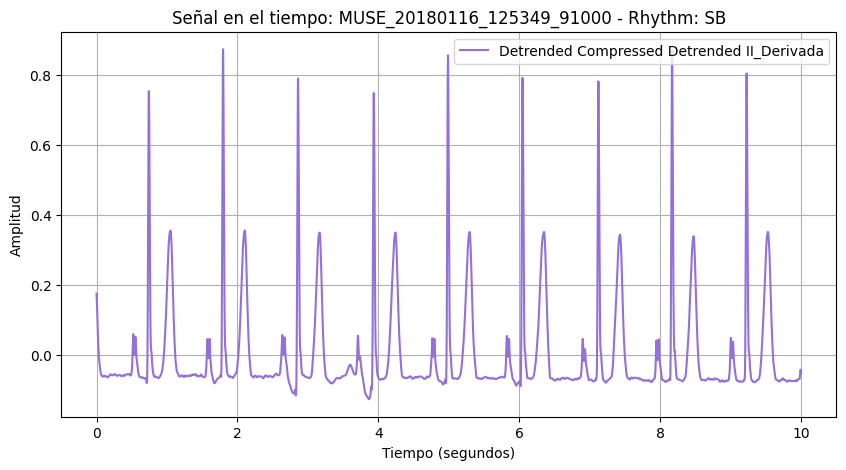

In [ ]:
# Frecuencia de muestreo en Hz
frecuencia_muestreo = 500  # Hz

# Seleccionar la fila 0
fila = df_II.iloc[0]  # Cambia el índice si deseas graficar otra fila

# Obtener la señal de la columna 'Detrended Compressed Detrended II_Derivada'
señal = fila['Detrended Compressed Detrended II_Derivada']

# Crear el eje de tiempo (en segundos)
duración_señal = len(señal) / frecuencia_muestreo  # Duración total en segundos
tiempo = np.linspace(0, duración_señal, len(señal), endpoint=False)

# Graficar la señal en el dominio del tiempo
plt.figure(figsize=(10, 5))
plt.plot(tiempo, señal, label='Detrended Compressed Detrended II_Derivada', color='mediumpurple')
plt.title(f"Señal en el tiempo: {fila['FileName']} - Rhythm: {fila['Rhythm']}")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()


# 3. Tutorial de Neurokit

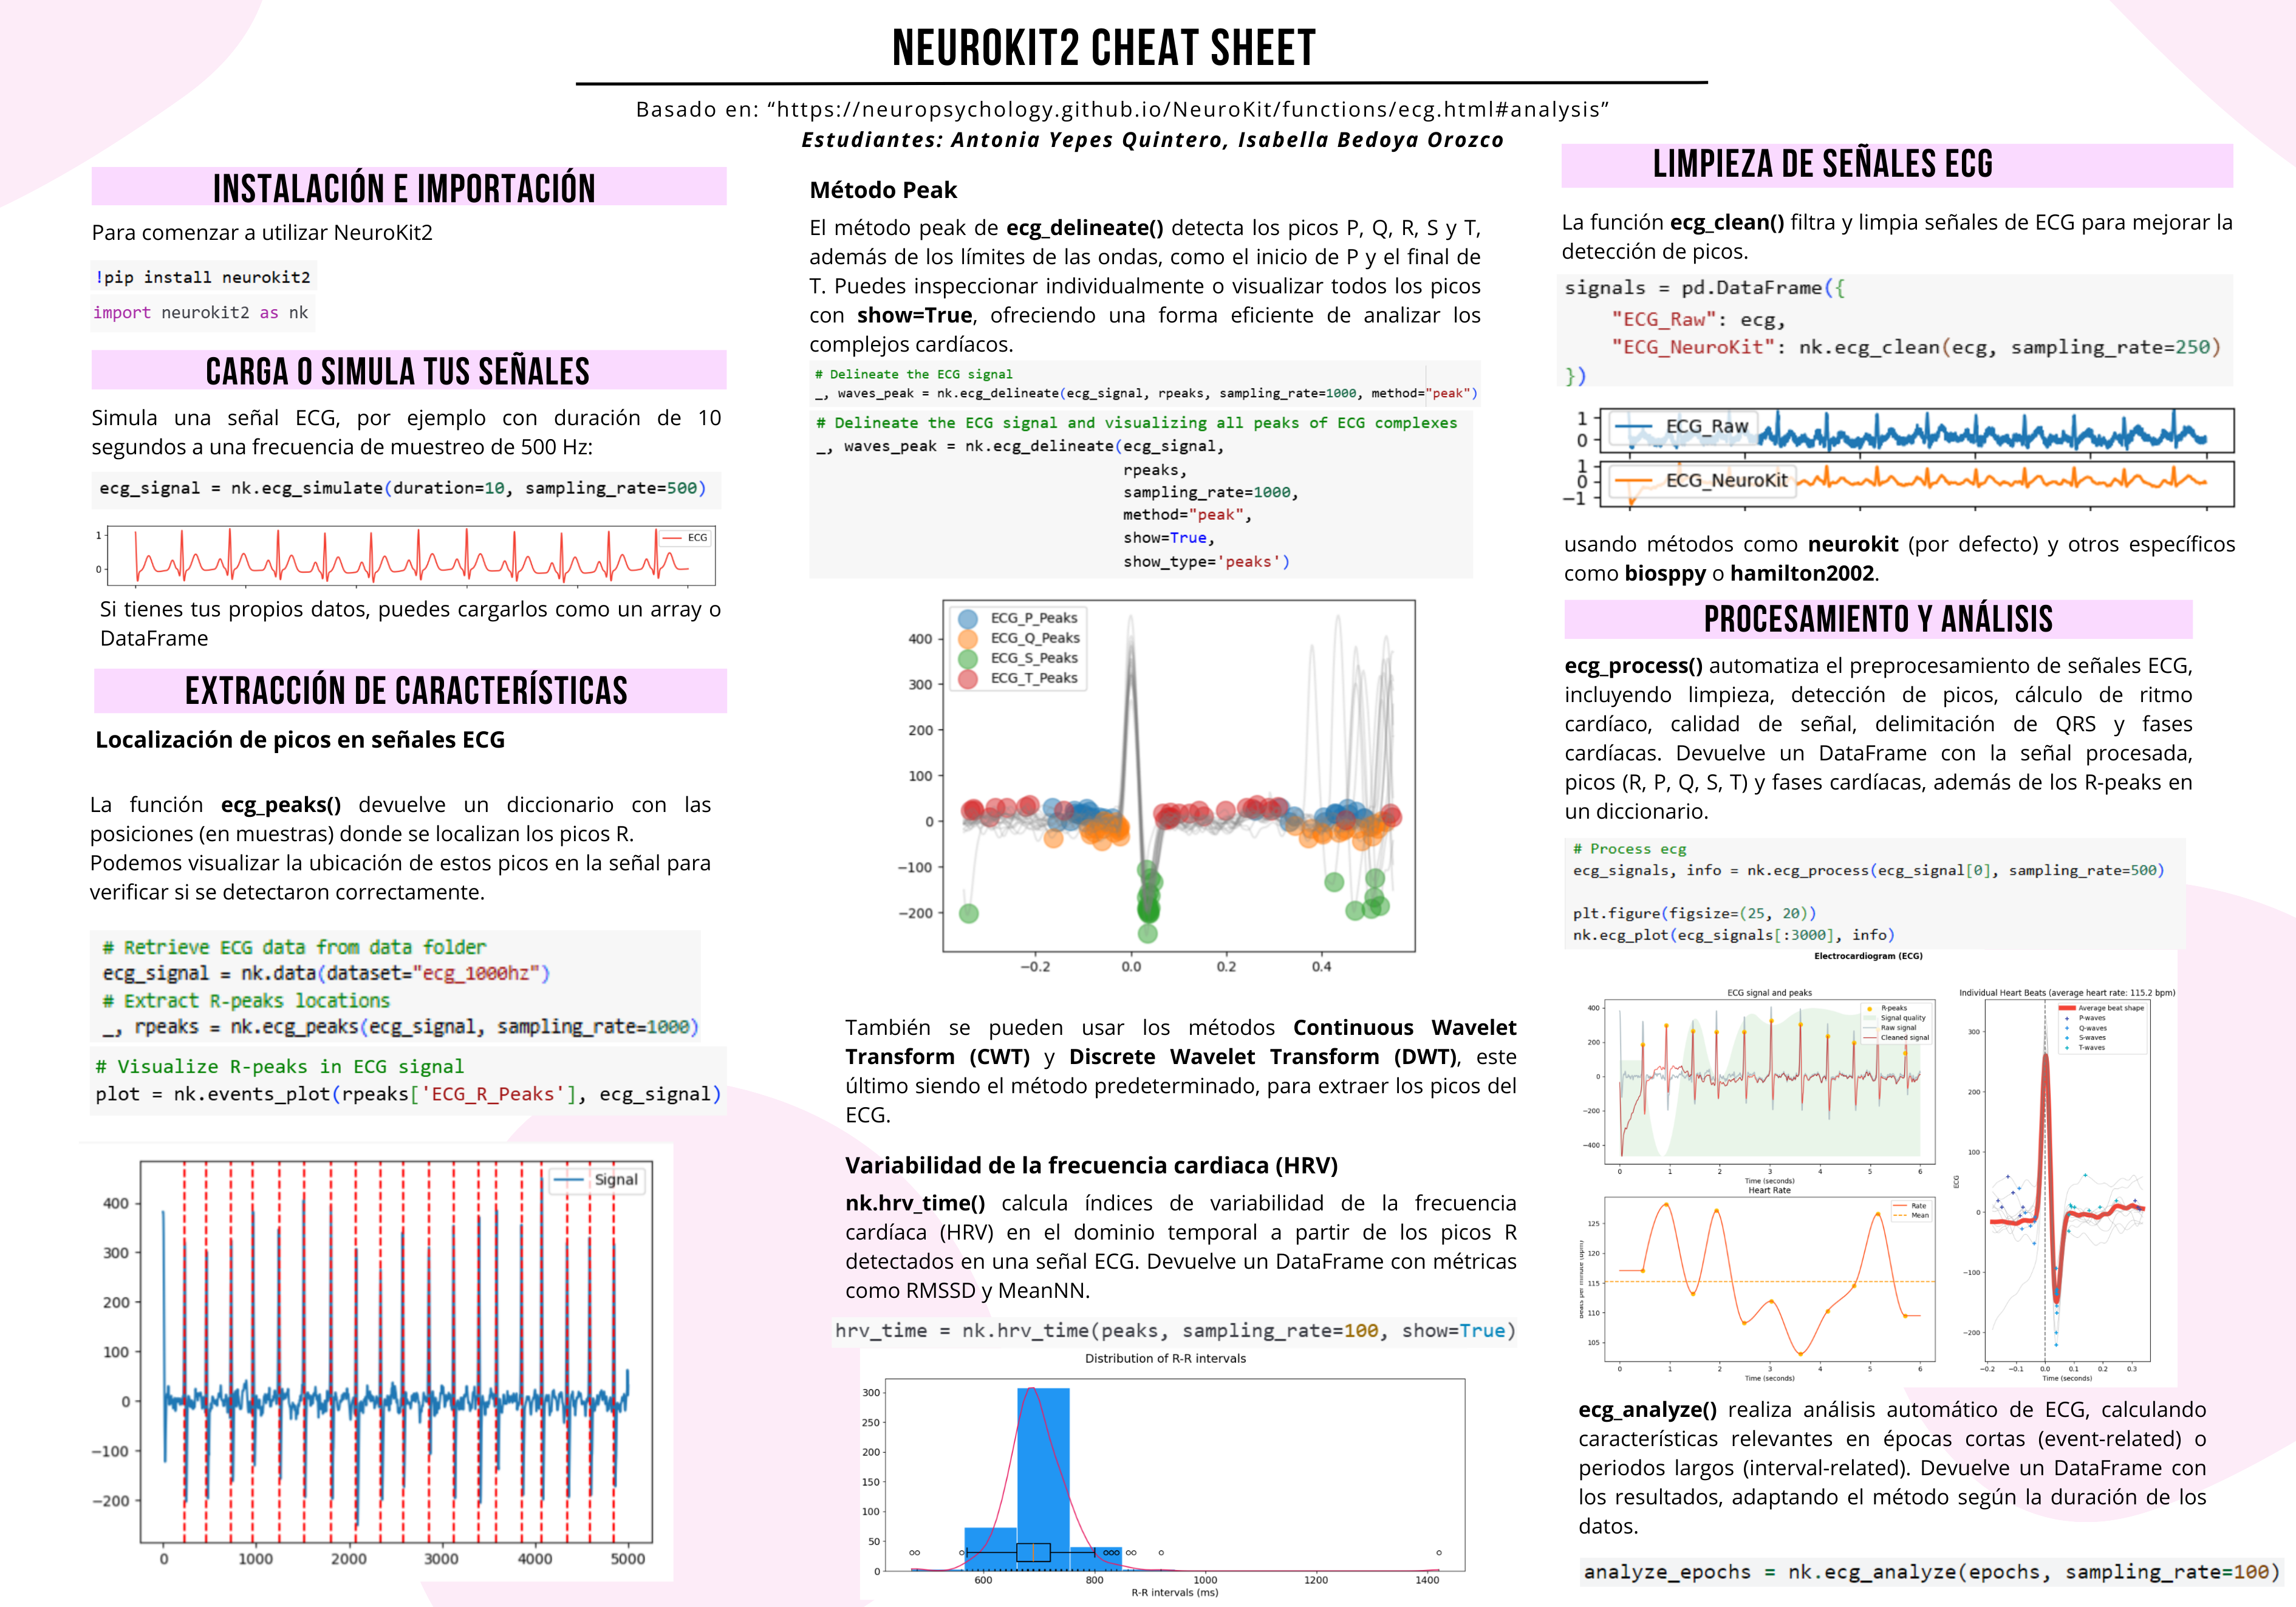

# 4. Aplicación de tutorial neurokit

### Extracción de caracteristicas automáticamente

Con esta podemos obtener ECG_Rate_Mean - ECG_Rate_SD - ECG_Phase_Atrial - ECG_Phase_Ventricular

In [ ]:
all_features = []

# Iterar sobre las primeras 10 señales
for i in range(10):
    ecg_signal = df_II['Detrended Compressed Detrended II_Derivada'].iloc[i]

    # Encontrar eventos en la señal
    events = nk.events_find(ecg_signal)

    # Preprocesar la señal
    data_clean, info = nk.bio_process(ecg_signal, sampling_rate=500)

    # Crear épocas alrededor de los eventos
    epochs = nk.epochs_create(data_clean, events, sampling_rate=500, epochs_start=1, epochs_end=9)

    # Extraer características automáticamente
    df_features = nk.bio_analyze(epochs, sampling_rate=500)

    # Agregar las características procesadas a la lista
    all_features.append(df_features)

df_all_features = pd.concat(all_features, ignore_index=True)
df_all_features

Label  Event_Onset  ECG_Rate_Baseline  ECG_Rate_Max  ECG_Rate_Min  \
0       1          867          57.033147      0.438117     -1.374520   
1       2         1392          56.330150      1.141115    -56.330150   
2       3         1925          55.870366      1.600898    -55.870366   
3       4         2463          57.022283      0.448981    -57.022283   
4       5         2989          56.742285      0.728979    -56.742285   
..    ...          ...                ...           ...           ...   
137    11         4009          89.859501     -0.088165    -89.859501   
138    12         4292          82.746234      1.999529    -82.746234   
139    13         4658          84.545918      0.199845    -84.545918   
140    14         5013           0.000000      0.000000      0.000000   
141    15         5368           0.000000      0.000000      0.000000   

     ECG_Rate_Mean  ECG_Rate_SD  ECG_Rate_Max_Time  ECG_Rate_Min_Time  \
0        -0.443783     0.508501           7.435609           6.391348   
1        -5.305221    16.828398           6.385346           8.217804   
2       -12.317759    23.895231           5.319080           7.151538   
3       -21.053082    27.322958           4.242811           6.075269   
4       -28.261535    28.334424           3.190548           5.023006   
..             ...          ...                ...                ...   
137     -69.030857    36.317639           1.002001           2.982496   
138     -67.843323    32.159012           2.160290           2.416354   
139     -77.323251    23.656058           1.428107           1.684171   
140       0.000000     0.000000           1.002007           1.002007   
141       0.000000     0.000000           1.002203           1.002203   

     ECG_Rate_Trend_Linear  ECG_Rate_Trend_Quadratic  ECG_Rate_Trend_R2  \
0                -0.239605                 -0.175422           0.175013   
1                15.390116                -24.467768           0.544353   
2                18.037798                -25.012534           0.787210   
3                 6.740968                 -4.426972           0.777261   
4                -9.916973                 23.383196           0.745518   
..                     ...                       ...                ...   
137             -48.742891                 62.493793           0.793933   
138             -46.269703                 51.075367           0.738287   
139             -30.644973                 -2.004319           0.502247   
140               0.000000                  0.000000           1.000000   
141               0.000000                  0.000000           1.000000   

     ECG_Phase_Atrial  ECG_Phase_Completion_Atrial  ECG_Phase_Ventricular  \
0                 1.0                     0.702970                    0.0   
1                 1.0                     0.648148                    0.0   
2                 1.0                     0.621622                    0.0   
3                 1.0                     0.711538                    0.0   
4                 1.0                     0.685714                    0.0   
..                ...                          ...                    ...   
137               0.0                     0.723549                    0.0   
138               0.0                     0.570175                    1.0   
139               0.0                     0.503597                    0.0   
140               0.0                     0.000000                    0.0   
141               0.0                     0.000000                    0.0   

     ECG_Phase_Completion_Ventricular  ECG_Quality_Mean  
0                            0.910448          0.747700  
1                            0.888889          0.669774  
2                            0.879310          0.547524  
3                            0.909910          0.430214  
4                            0.902367          0.322443  
..                                ...               ...  
137               

### Variabilidad de la frecuencia cardiaca

Con esto podemos obtener HRV_MeanNN - HRV_SDNN

* HRV_MeanNN:The mean of the RR intervals
* HRV_SDNN: The standard deviation of the RR intervals.

HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  1060.250000   10.498299         NaN         NaN         NaN         NaN   
1  1177.142857  395.087935         NaN         NaN         NaN         NaN   
2  1056.500000   27.666380         NaN         NaN         NaN         NaN   
3   702.461538  146.517698         NaN         NaN         NaN         NaN   
4  1119.250000   40.986932         NaN         NaN         NaN         NaN   
5   505.444444   94.517488         NaN         NaN         NaN         NaN   
6  1034.888889   17.149668         NaN         NaN         NaN         NaN   
7  1372.000000   24.657656         NaN         NaN         NaN         NaN   
8   470.631579   86.623201         NaN         NaN         NaN         NaN   
9   685.230769   92.001951         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN   17.020995   18.361450  ...       13.0   
1         NaN         NaN  452.014012  493.669930  ...      529.0   
2         NaN         NaN   26.087764   26.917864  ...       20.0   
3         NaN         NaN  208.164999  215.538789  ...      270.0   
4         NaN         NaN   46.037252   47.169401  ...       15.5   
5         NaN         NaN  160.605472  165.546155  ...      106.5   
6         NaN         NaN   22.627417   24.183820  ...       14.0   
7         NaN         NaN   41.799522   46.182248  ...       30.5   
8         NaN         NaN  131.068260  134.650407  ...      107.0   
9         NaN         NaN  158.857378  165.701722  ...      114.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     0.616785       1052.8       1070.0   0.000000  12.500000     1046.0   
1     0.874061        874.0       1526.0  85.714286  85.714286      740.0   
2     1.060512       1040.8       1072.0   0.000000  50.000000     1008.0   
3     0.703854        541.6        839.2  76.923077  76.923077      470.0   
4     0.890299       1115.2       1141.2  12.500000  50.000000     1024.0   
5     0.588507        407.6        544.4  61.111111  72.222222      370.0   
6     0.757915       1024.4       1046.4   0.000000  33.333333     1002.0   
7     0.589903       1350.0       1388.0  33.333333  50.000000     1336.0   
8     0.660901        404.0        523.6  47.368421  73.684211      354.0   
9     0.579148        613.6        733.6  61.538462  76.923077      566.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     1076.0   4.000000    0.0000  
1     1802.0   7.000000    0.0000  
2     1100.0   4.000000   62.5000  
3      902.0  13.000000    0.0000  
4     1156.0   2.666667  101.5625  
5      764.0   9.000000   39.0625  
6     1058.0   3.000000   39.0625  
7     1402.0   6.000000    0.0000  
8      674.0   9.500000   15.6250  
9      880.0   6.500000    0.0000  

[10 rows x 25 columns]

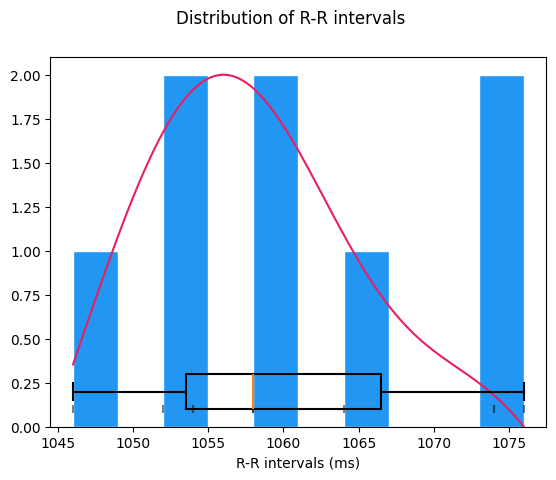

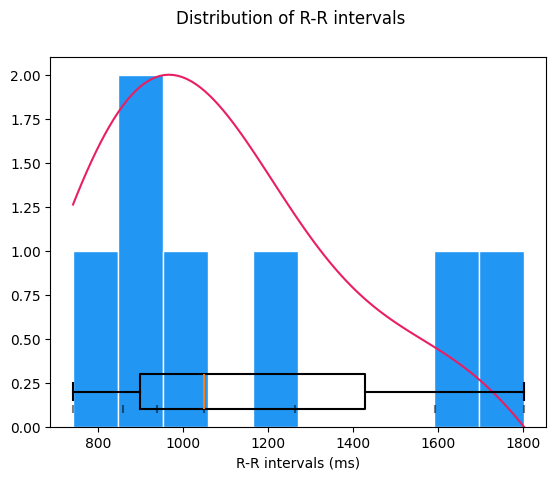

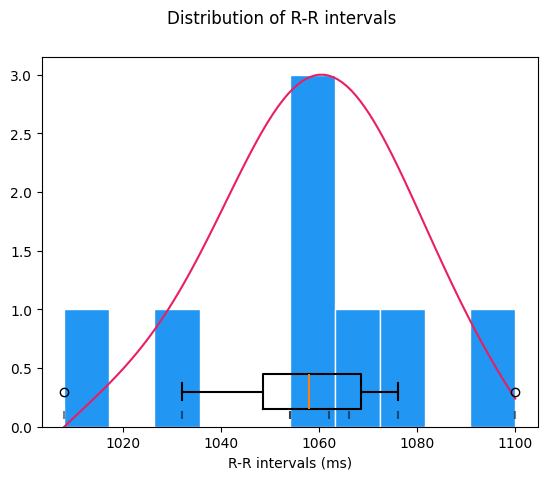

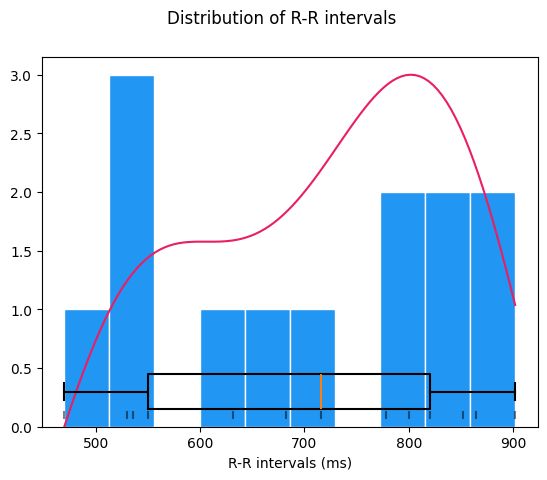

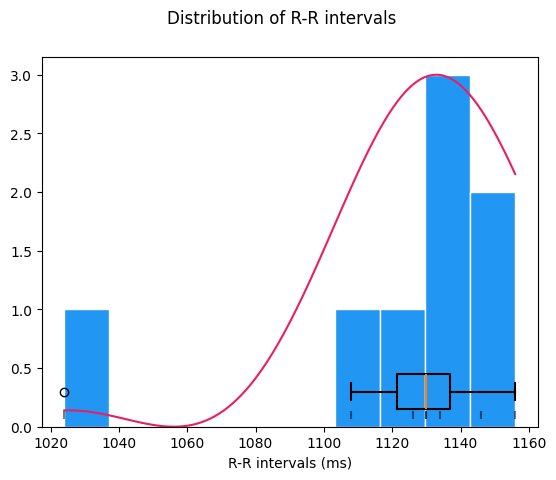

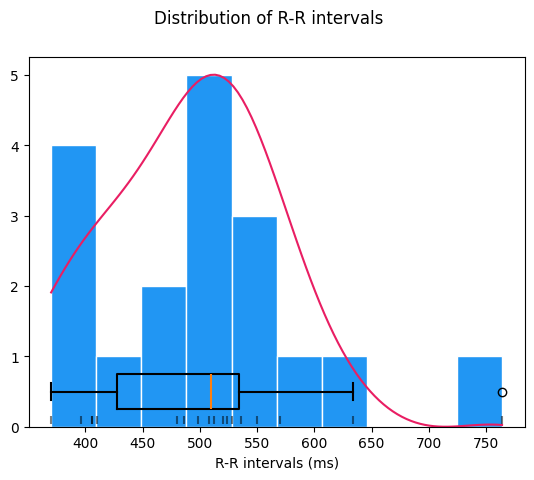

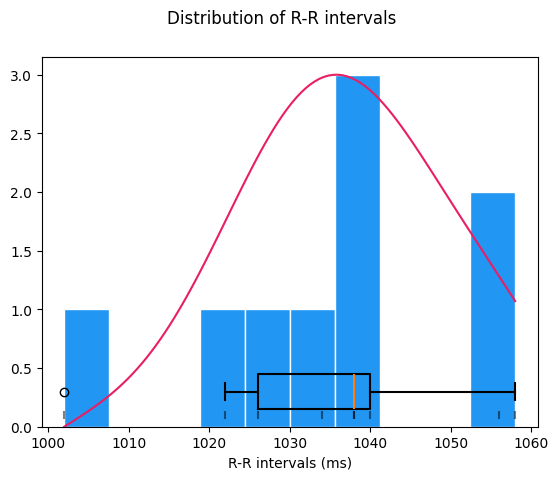

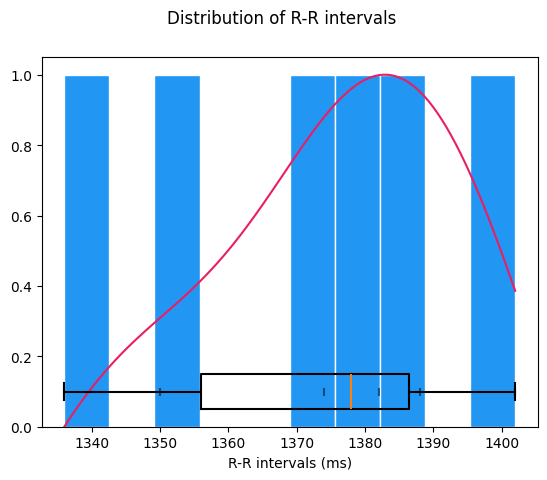

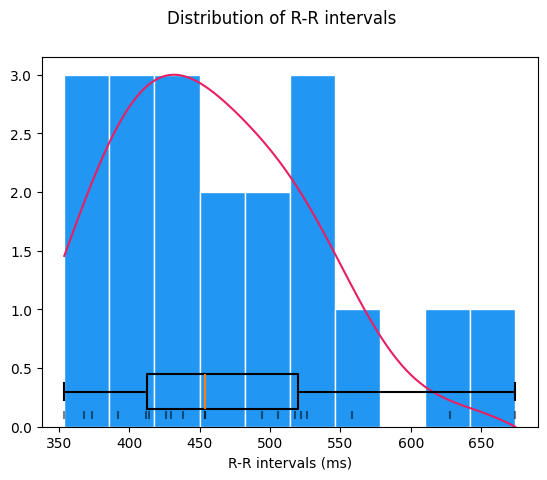

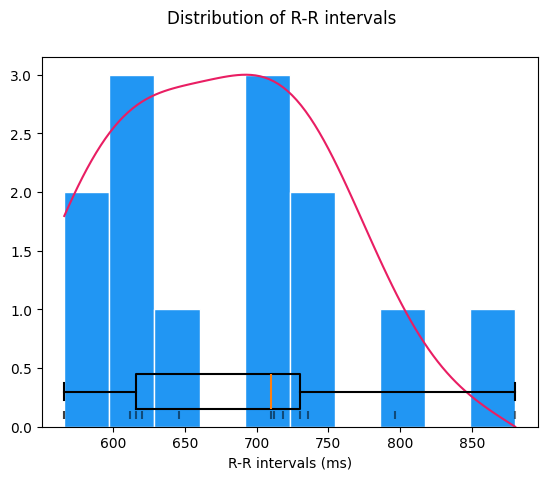

In [ ]:
all_hrv_features = []

for i in range(10):
    ecg_signal = df_II['Detrended Compressed Detrended II_Derivada'].iloc[i]

    # Encontrar los picos en la señal
    peaks, info = nk.ecg_peaks(ecg_signal, sampling_rate=500)

    # Extraer características de HRV en el dominio del tiempo
    hrv_time = nk.hrv_time(peaks, sampling_rate=500, show=True)

    # Agregar las características de HRV a la lista
    all_hrv_features.append(hrv_time)

df_all_hrv_features = pd.concat(all_hrv_features, ignore_index=True)
df_all_hrv_features


### Localizar la onda P

Esto será util para poder extraer la cantidad de ondas P. Esto es importante porque una ausencia o alteración en el P Onset puede indicar un ritmo auricular no sinusal.


In [ ]:
all_p_peaks = []

for i in range(10):
    # Obtener la señal actual
    ecg_signal = df_II['Detrended Compressed Detrended II_Derivada'].iloc[i]

    # Extraer las ubicaciones de los picos R
    _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=500)

    # Delinear la señal ECG para obtener las ondas P
    _, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=1000, method="peak")

    # Extraer los picos P
    picos_p = waves_peak['ECG_P_Peaks']

    # Contar la cantidad de picos P no nulos
    cantidad_picos_p = np.sum(~np.isnan(picos_p))

    # Agregar el resultado a la lista
    all_p_peaks.append({"Signal_Index": i, "Cantidad_Picos_P": cantidad_picos_p})

df_p_peaks = pd.DataFrame(all_p_peaks)
df_p_peaks


Signal_Index  Cantidad_Picos_P
0             0                 8
1             1                 7
2             2                 8
3             3                 8
4             4                 8
5             5                 8
6             6                 9
7             7                 6
8             8                 1
9             9                 2

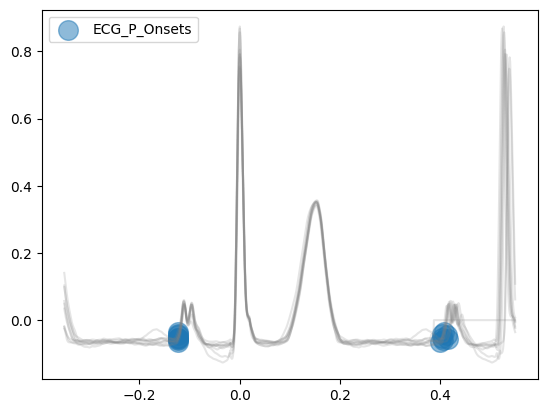

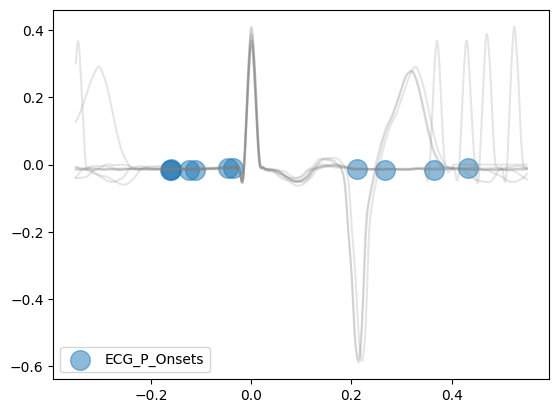

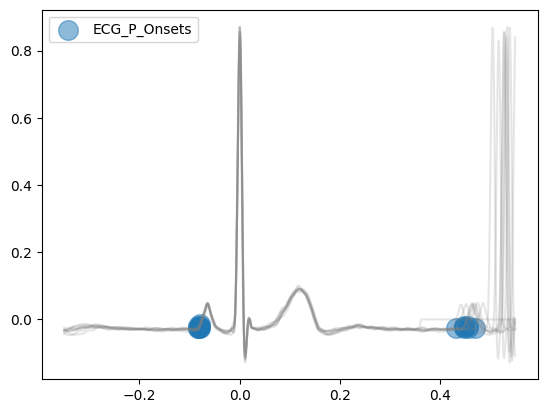

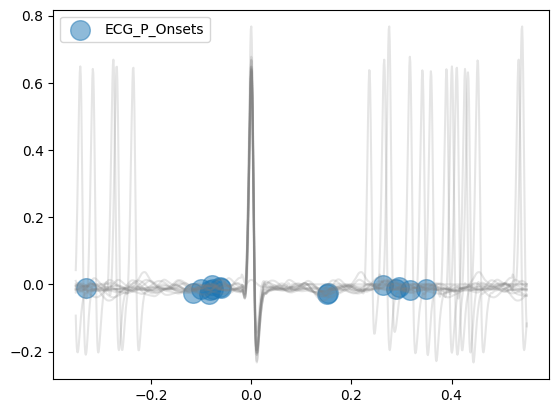

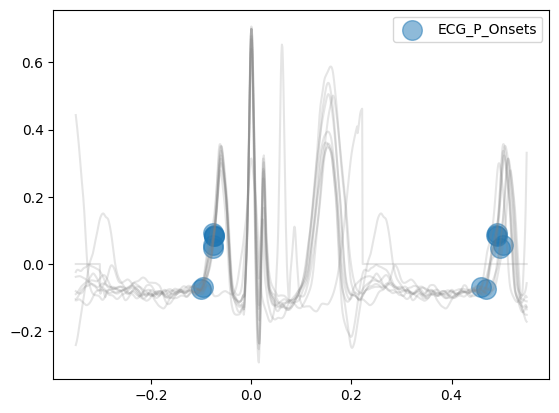

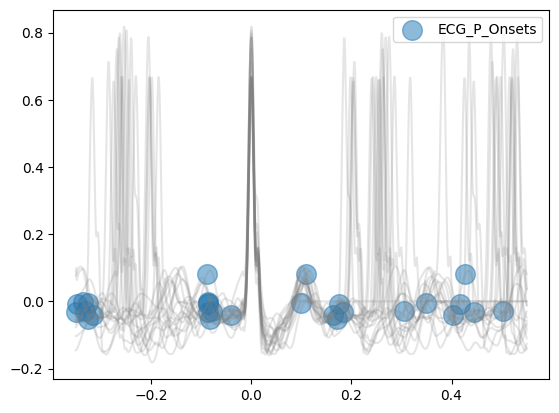

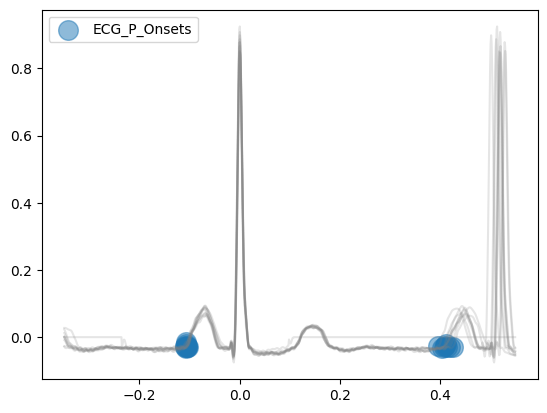

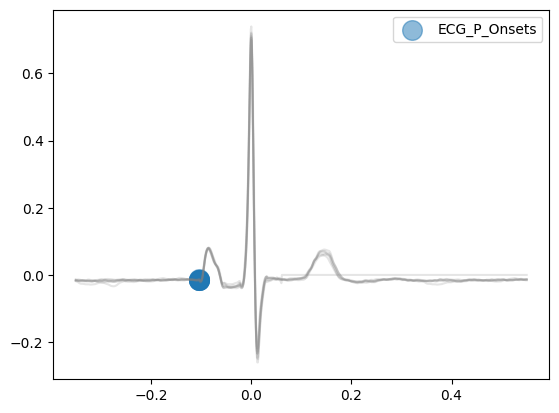

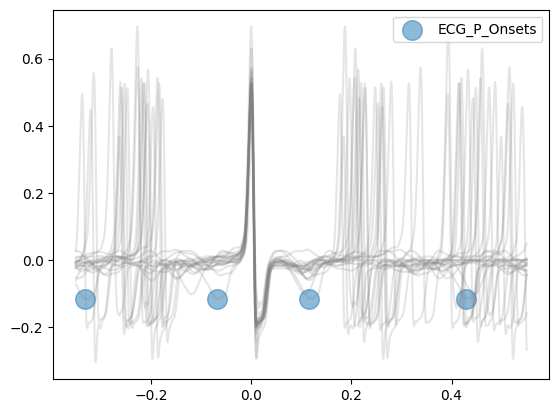

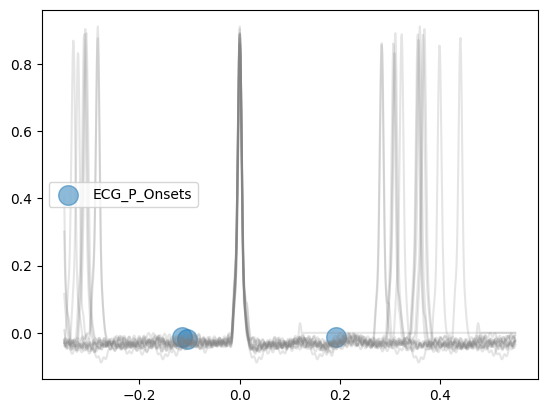

In [ ]:
for i in range(10):
    # Obtener la señal actual
    ecg_signal = df_II['Detrended Compressed Detrended II_Derivada'].iloc[i]

    # Extraer las ubicaciones de los picos R
    _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=500)

    # Delinear la señal ECG y visualizar los límites de las ondas P
    signal_peak, waves_peak = nk.ecg_delineate(
        ecg_signal,
        rpeaks,
        sampling_rate=1000,
        method="peak",
        show=True,  # Genera la visualización
        show_type='bounds_P'  # Especifica los límites de las ondas P
    )


### Ver calidad de la señal ECG

* Panel superior izquierdo: Señal ECG cruda y limpia con detección de picos R.
* Panel inferior izquierdo: Variabilidad de la frecuencia cardíaca.
* Panel derecho: Morfología promedio de los latidos con ondas destacadas.

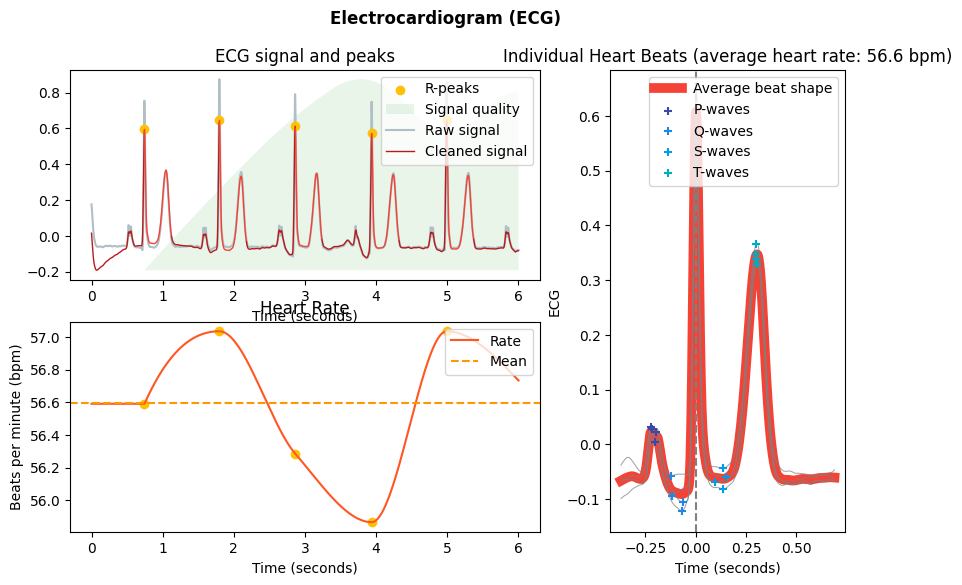

In [ ]:
# Graficar señal ECG
nk.ecg_plot(data_clean[:3000], info=info)

# 5.Extracción de caracteristicas

### Extracción de Edad - Genero - fMP

In [ ]:
def max_frequency_power(signal, fs=500):
    # Realizar la FFT
    EKG = fft(signal)
    N = len(signal)  # Número de puntos en la señal

    # Calcular las frecuencias correspondientes
    f = np.arange(0, fs, fs/N)

    # Calcular el espectro de potencia (PSD)
    power_spectrum = np.power(np.abs(EKG), 2) / N

    # Extraer la frecuencia que contiene la máxima potencia
    max_power_index = np.argmax(power_spectrum[:N//2])  # Solo tomamos la mitad positiva
    max_frequency = f[max_power_index]

    return max_frequency

In [ ]:
# Aplicar la función a cada señal en la columna 'Detrended Compressed Detrended II_Derivada'
df_II['fMP'] = df_II['Detrended Compressed Detrended II_Derivada'].apply(lambda x: max_frequency_power(np.array(x)))

# Mostrar el DataFrame con la nueva columna
df_II[['PatientAge', 'Gender', 'fMP','Rhythm']]

PatientAge  Gender   fMP Rhythm
0             71    MALE   3.8     SB
1             55  FEMALE   1.5   AFIB
2             24    MALE   0.9     SB
3             91  FEMALE  20.9   AFIB
4             73    MALE   4.4     SB
...          ...     ...   ...    ...
2095          71  FEMALE   3.4   AFIB
2096          76    MALE   2.1   AFIB
2097          89  FEMALE   2.5   AFIB
2098          68  FEMALE   3.9   AFIB
2099          59    MALE   1.9     SB

[2100 rows x 4 columns]

### Extracción de ECG_Rate_Mean - ECG_Rate_SD - ECG_Phase_Atrial - ECG_Phase_Ventricular

In [ ]:
def process_single_signal(signal, sampling_rate=500):
    try:
        # Procesar la señal individualmente
        events = nk.events_find(signal)
        data_clean, info = nk.bio_process(signal, sampling_rate=sampling_rate)
        epochs = nk.epochs_create(data_clean, events, sampling_rate=sampling_rate, epochs_start=1, epochs_end=9)
        df_features = nk.bio_analyze(epochs, sampling_rate=sampling_rate)

        # Seleccionar columnas relevantes y calcular promedios
        selected_columns = ["ECG_Rate_Mean", "ECG_Rate_SD", "ECG_Phase_Atrial", "ECG_Phase_Ventricular"]
        averaged_features = df_features[selected_columns].mean()

        return averaged_features
    except Exception as e:
        print(f"Error procesando la señal: {e}")
        # Devolver un diccionario vacío en caso de error
        return pd.Series({col: None for col in ["ECG_Rate_Mean", "ECG_Rate_SD", "ECG_Phase_Atrial", "ECG_Phase_Ventricular"]})

def process_ecg_signals_parallel(df, signal_column, sampling_rate=500, n_jobs=-1):
    """
    Procesa todas las señales en paralelo para extraer las características relevantes.
    """
    # Extraer todas las señales
    signals = df[signal_column]

    # Procesar señales en paralelo
    all_features = Parallel(n_jobs=n_jobs)(delayed(process_single_signal)(signal, sampling_rate) for signal in signals)

    # Combinar los resultados en un DataFrame
    result_df = pd.DataFrame(all_features)

    # Reemplazar NaN con el promedio de cada columna
    result_df.fillna(result_df.mean(), inplace=True)

    return result_df

# Aplicar la función al DataFrame
result_parallel = process_ecg_signals_parallel(df_II, signal_column="Detrended Compressed Detrended II_Derivada", sampling_rate=500)

# Mostrar los resultados
result_parallel

ECG_Rate_Mean  ECG_Rate_SD  ECG_Phase_Atrial  ECG_Phase_Ventricular
0        -21.876137    18.439273          0.888889               0.000000
1        -12.027725    15.643995          0.250000               1.000000
2        -22.307653    18.938372          0.888889               0.000000
3        -37.479769    30.549115          0.083333               0.250000
4        -20.794076    26.774724          0.437500               0.281250
...             ...          ...               ...                    ...
2095     -29.422792    26.444262          0.000000               0.571429
2096     -25.456706    21.020980          0.076923               0.666667
2097     -62.108664    54.417003          0.047619               0.714286
2098     -34.720044    28.786671          0.083333               0.384615
2099     -21.574479    17.596303          0.846154               0.076923

[2100 rows x 4 columns]

### Extracción de HRV_MeanNN -	HRV_SDNN

In [ ]:
import pandas as pd
import neurokit2 as nk

def process_single_signal(signal, sampling_rate=500):
    try:
        # Procesar la señal individualmente
        peaks, info = nk.ecg_peaks(signal, sampling_rate=sampling_rate)
        hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_rate)

        # Extraer solo los valores numéricos de las columnas seleccionadas
        return {
            "HRV_MeanNN": hrv_time["HRV_MeanNN"].iloc[0] if not hrv_time["HRV_MeanNN"].isnull().all() else None,
            "HRV_SDNN": hrv_time["HRV_SDNN"].iloc[0] if not hrv_time["HRV_SDNN"].isnull().all() else None,
        }
    except Exception as e:
        print(f"Error procesando la señal: {e}")
        return {"HRV_MeanNN": None, "HRV_SDNN": None}

def process_ecg_signals_parallel(df, signal_column, sampling_rate=500, n_jobs=-1):
    from joblib import Parallel, delayed

    # Extraer todas las señales
    signals = df[signal_column]

    # Procesar señales en paralelo
    all_features = Parallel(n_jobs=n_jobs)(delayed(process_single_signal)(signal, sampling_rate) for signal in signals)

    # Combinar los resultados en un DataFrame
    result_df = pd.DataFrame(all_features)

    # Reemplazar NaN con el promedio de cada columna
    result_df.fillna(result_df.mean(), inplace=True)

    return result_df

# Aplicar la función al DataFrame
result_parallel2 = process_ecg_signals_parallel(df_II, signal_column="Detrended Compressed Detrended II_Derivada", sampling_rate=500)

# Mostrar los resultados
result_parallel2


HRV_MeanNN    HRV_SDNN
0     1060.250000   10.498299
1     1177.142857  395.087935
2     1056.500000   27.666380
3      702.461538  146.517698
4     1119.250000   40.986932
...           ...         ...
2095   751.666667  120.395812
2096   855.200000  270.780272
2097   417.727273   90.421859
2098   752.000000  182.230623
2099  1040.444444   32.199034

[2100 rows x 2 columns]

### Extracción de la cantidad de ondas P

In [ ]:
def contar_picos_p_ecg(signal, sampling_rate_rpeaks=500, sampling_rate_delineate=1000):
    try:
        # Detectar R-peaks
        _, rpeaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate_rpeaks)

        # Validar que hay suficientes picos R detectados
        if len(rpeaks['ECG_R_Peaks']) == 0:
            return 0  # No hay picos R detectados, no puede continuar

        # Delimitar ondas ECG
        _, waves_peak = nk.ecg_delineate(
            signal,
            rpeaks,
            sampling_rate=sampling_rate_delineate,
            method="peak"
        )

        # Obtener los picos P
        picos_p = waves_peak['ECG_P_Peaks']

        # Contar picos P diferentes de NaN
        cantidad_picos_p = np.sum(~np.isnan(picos_p))

        return cantidad_picos_p
    except Exception as e:
        # En caso de error, retorna 0 y evita que el proceso falle
        print(f"Error procesando la señal: {e}")
        return 0

# Aplicar la función a cada señal en la columna
df_II['Cantidad_Picos_P'] = df_II['Detrended Compressed Detrended II_Derivada'].apply(lambda x: contar_picos_p_ecg(np.array(x)))

# Mostrar los resultados
df_II[['Cantidad_Picos_P']]


Cantidad_Picos_P
0                    8
1                    7
2                    8
3                    8
4                    8
...                ...
2095                12
2096                10
2097                 1
2098                 7
2099                 8

[2100 rows x 1 columns]

# 6. Creación de rutina

In [ ]:
# Combinar todos los DataFrames en uno solo
df_total = pd.concat([
    df_II[['PatientAge', 'Gender', 'fMP', 'Rhythm']],  # Seleccionar columnas de df_II
    result_parallel[['ECG_Rate_Mean', 'ECG_Rate_SD', 'ECG_Phase_Atrial', 'ECG_Phase_Ventricular']],  # De result_parallel
    result_parallel2[['HRV_MeanNN', 'HRV_SDNN']],  # De result_parallel2
    df_II[['Cantidad_Picos_P']]  # Cantidad de picos P
], axis=1)

# Verificar el orden de las columnas
df_total = df_total[['PatientAge', 'Gender', 'fMP', 'ECG_Rate_Mean', 'ECG_Rate_SD',
                     'ECG_Phase_Atrial', 'ECG_Phase_Ventricular', 'HRV_MeanNN',
                     'HRV_SDNN', 'Cantidad_Picos_P', 'Rhythm']]

# Mostrar el DataFrame final
df_total


PatientAge  Gender   fMP  ECG_Rate_Mean  ECG_Rate_SD  ECG_Phase_Atrial  \
0             71    MALE   3.8     -21.876137    18.439273          0.888889   
1             55  FEMALE   1.5     -12.027725    15.643995          0.250000   
2             24    MALE   0.9     -22.307653    18.938372          0.888889   
3             91  FEMALE  20.9     -37.479769    30.549115          0.083333   
4             73    MALE   4.4     -20.794076    26.774724          0.437500   
...          ...     ...   ...            ...          ...               ...   
2095          71  FEMALE   3.4     -29.422792    26.444262          0.000000   
2096          76    MALE   2.1     -25.456706    21.020980          0.076923   
2097          89  FEMALE   2.5     -62.108664    54.417003          0.047619   
2098          68  FEMALE   3.9     -34.720044    28.786671          0.083333   
2099          59    MALE   1.9     -21.574479    17.596303          0.846154   

      ECG_Phase_Ventricular   HRV_MeanNN    HRV_SDNN  Cantidad_Picos_P Rhythm  
0                  0.000000  1060.250000   10.498299                 8     SB  
1                  1.000000  1177.142857  395.087935                 7   AFIB  
2                  0.000000  1056.500000   27.666380                 8     SB  
3                  0.250000   702.461538  146.517698                 8   AFIB  
4                  0.281250  1119.250000   40.986932                 8     SB  
...                     ...          ...         ...               ...    ...  
2095               0.571429   751.666667  120.395812                12   AFIB  
2096               0.666667   855.200000  270.780272                10   AFIB  
2097               0.714286   417.727273   90.421859                 1   AFIB  
2098               0.384615   752.000000  182.230623                 7   AFIB  
2099               0.076923  1040.444444   32.199034                 8     SB  

[2100 rows x 11 columns]

### Convertir Gender y Rhythm en numericos

In [ ]:
# Asignar valores numéricos a la columna 'Gender'
df_total['Gender'] = df_total['Gender'].map({'FEMALE': 0, 'MALE': 1})

# Asignar valores numéricos a la columna 'Rhythm'
# Por ejemplo, asignando 0 a 'AFIB' y 1 a 'SB'
df_total['Rhythm'] = df_total['Rhythm'].map({'AFIB': 0, 'SB': 1})

# Verificar el resultado
df_total


PatientAge  Gender   fMP  ECG_Rate_Mean  ECG_Rate_SD  ECG_Phase_Atrial  \
0             71       1   3.8     -21.876137    18.439273          0.888889   
1             55       0   1.5     -12.027725    15.643995          0.250000   
2             24       1   0.9     -22.307653    18.938372          0.888889   
3             91       0  20.9     -37.479769    30.549115          0.083333   
4             73       1   4.4     -20.794076    26.774724          0.437500   
...          ...     ...   ...            ...          ...               ...   
2095          71       0   3.4     -29.422792    26.444262          0.000000   
2096          76       1   2.1     -25.456706    21.020980          0.076923   
2097          89       0   2.5     -62.108664    54.417003          0.047619   
2098          68       0   3.9     -34.720044    28.786671          0.083333   
2099          59       1   1.9     -21.574479    17.596303          0.846154   

      ECG_Phase_Ventricular   HRV_MeanNN    HRV_SDNN  Cantidad_Picos_P  Rhythm  
0                  0.000000  1060.250000   10.498299                 8       1  
1                  1.000000  1177.142857  395.087935                 7       0  
2                  0.000000  1056.500000   27.666380                 8       1  
3                  0.250000   702.461538  146.517698                 8       0  
4                  0.281250  1119.250000   40.986932                 8       1  
...                     ...          ...         ...               ...     ...  
2095               0.571429   751.666667  120.395812                12       0  
2096               0.666667   855.200000  270.780272                10       0  
2097               0.714286   417.727273   90.421859                 1       0  
2098               0.384615   752.000000  182.230623                 7       0  
2099               0.076923  1040.444444   32.199034                 8       1  

[2100 rows x 11 columns]

### Aplicación de Z-score

Para estandarizar los datos y poder luego aplicarlo al modelo

In [ ]:
# Seleccionar las columnas numéricas para aplicar z-score (excluir las categóricas)
columnas_numericas = ['PatientAge', 'fMP', 'ECG_Rate_Mean', 'ECG_Rate_SD',
                      'ECG_Phase_Atrial', 'ECG_Phase_Ventricular', 'HRV_MeanNN',
                      'HRV_SDNN', 'Cantidad_Picos_P']

# Aplicar z-score a las columnas seleccionadas
df_total_zscore = df_total.copy()
df_total_zscore[columnas_numericas] = df_total_zscore[columnas_numericas].apply(zscore)

# Verificar el resultado
df_total_zscore.head()


PatientAge  Gender       fMP  ECG_Rate_Mean  ECG_Rate_SD  ECG_Phase_Atrial  \
0    0.369709       1  0.130802       0.713305    -0.722574          1.719607   
1   -0.490556       0 -0.639370       1.550751    -0.992883         -0.404772   
2   -2.157319       1 -0.840284       0.676611    -0.674310          1.719607   
3    1.445040       0  5.856861      -0.613529     0.448471         -0.958958   
4    0.477242       1  0.331716       0.805316     0.083480          0.218687   

   ECG_Phase_Ventricular  HRV_MeanNN  HRV_SDNN  Cantidad_Picos_P  Rhythm  
0              -1.174745    0.727600 -1.056912          0.176742       1  
1               2.674324    1.201567  3.357792         -0.095968       0  
2              -1.174745    0.712395 -0.859840          0.176742       1  
3              -0.212477   -0.723129  0.504454          0.176742       0  
4              -0.092194    0.966828 -0.706933          0.176742       1

De los artículos [3 - 6], se destaca la importancia de las siguientes características:

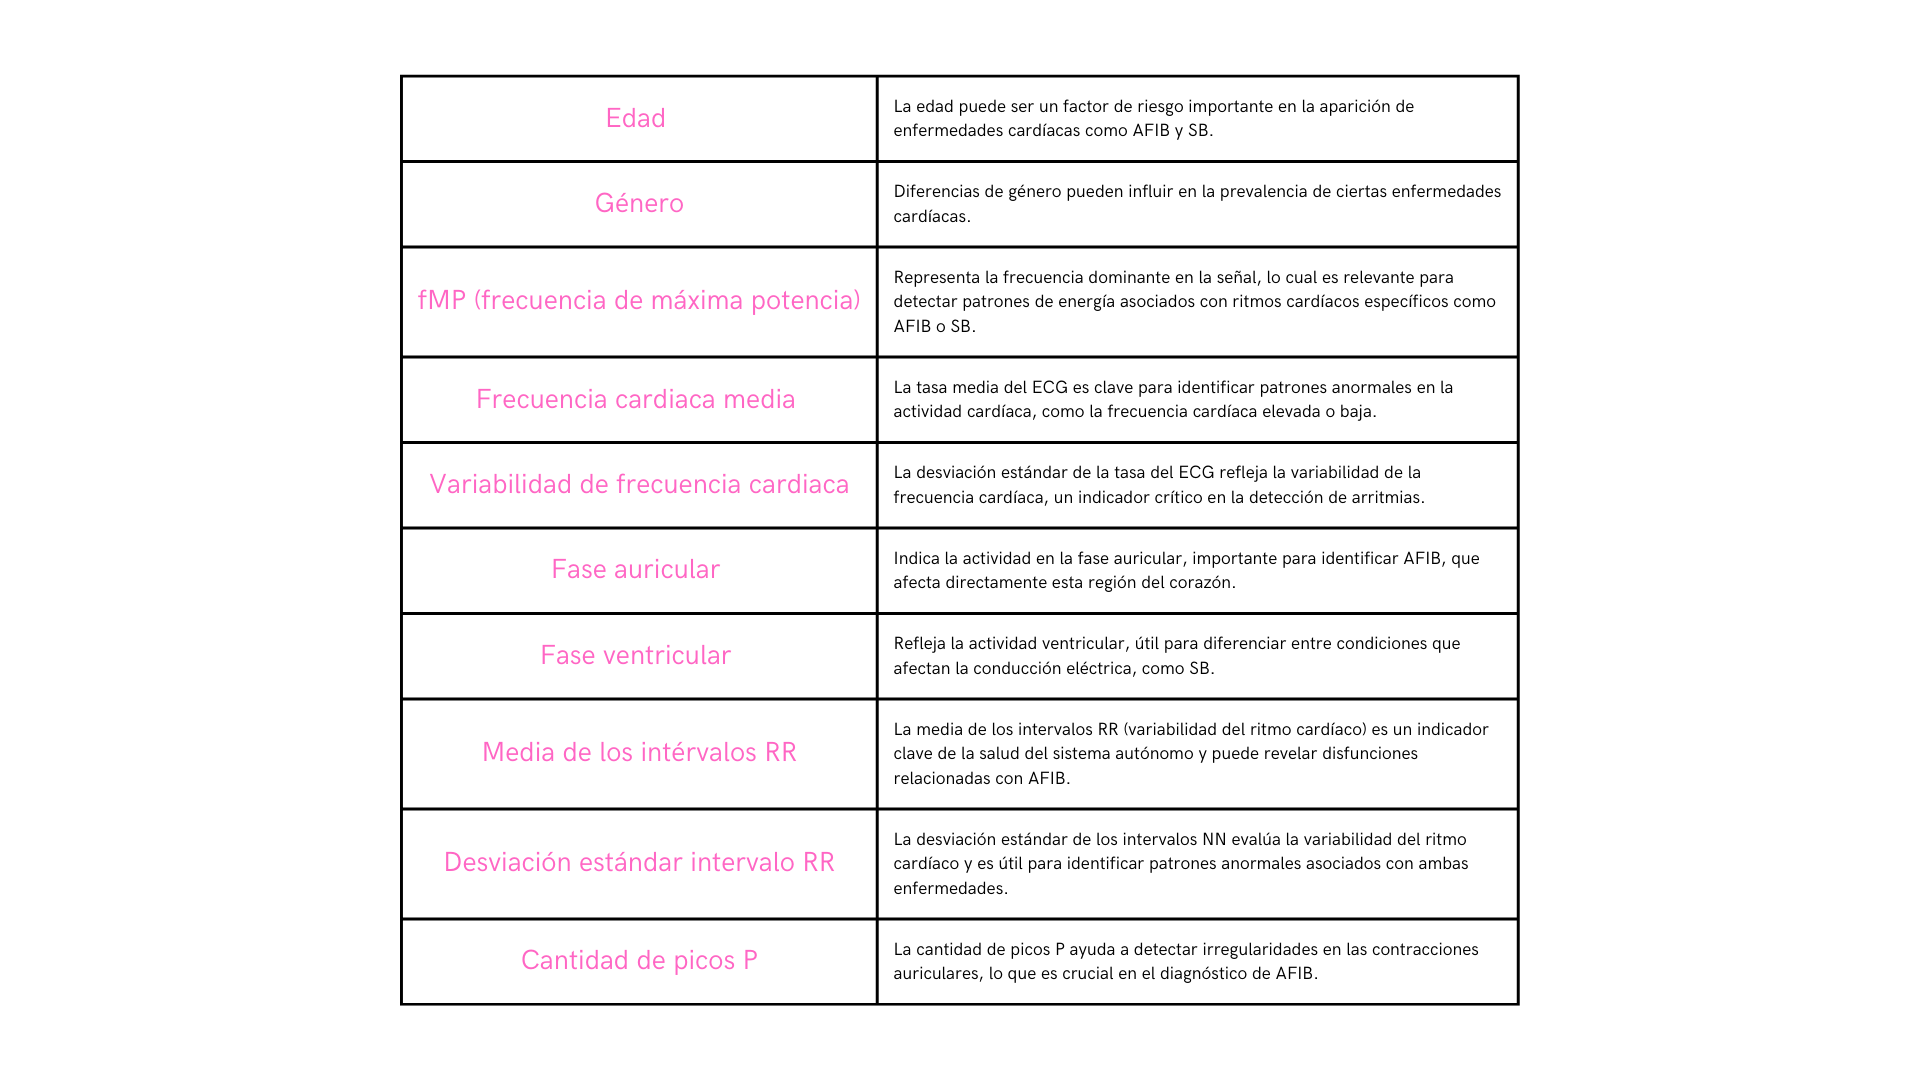     

# 7. Clasificación de las 2 patologías
## Usando: 3 diferentes arquitecturas de red

### Estadísticas descriptivas resumidas

In [ ]:
df_total_zscore.describe()

PatientAge       Gender           fMP  ECG_Rate_Mean   ECG_Rate_SD  \
count  2.100000e+03  2100.000000  2.100000e+03   2.100000e+03  2.100000e+03   
mean  -1.657933e-16     0.618095 -1.048896e-16   1.691768e-17  1.691768e-18   
std    1.000238e+00     0.485969  1.000238e+00   1.000238e+00  1.000238e+00   
min   -2.910051e+00     0.000000 -1.074684e+00  -4.249976e+00 -2.394261e+00   
25%   -5.980889e-01     0.000000 -6.058843e-01  -5.474400e-01 -7.899812e-01   
50%    2.084094e-01     1.000000 -1.705699e-01   4.058866e-01 -4.208679e-01   
75%    7.998415e-01     1.000000  1.977731e-01   6.911972e-01  6.612089e-01   
max    1.821406e+00     1.000000  1.560121e+01   6.242622e+00  3.225488e+00   

       ECG_Phase_Atrial  ECG_Phase_Ventricular    HRV_MeanNN      HRV_SDNN  \
count      2.100000e+03           2.100000e+03  2.100000e+03  2.100000e+03   
mean       6.809368e-17           4.398598e-17 -1.387250e-16 -1.734063e-17   
std        1.000238e+00           1.000238e+00  1.000238e+00  1.000238e+00   
min       -1.236051e+00          -1.174745e+00 -2.125436e+00 -1.160341e+00   
25%       -7.927020e-01          -1.174745e+00 -8.786119e-01 -8.355211e-01   
50%       -3.292012e-01          -2.002383e-02  4.283398e-01 -1.907838e-01   
75%        8.421460e-01           6.581455e-01  7.684006e-01  5.226953e-01   
max        2.089064e+00           2.674324e+00  2.682580e+00  9.532714e+00   

       Cantidad_Picos_P       Rhythm  
count      2.100000e+03  2100.000000  
mean       6.767074e-17     0.500000  
std        1.000238e+00     0.500119  
min       -2.004937e+00     0.000000  
25%       -3.686777e-01     0.000000  
50%        1.767420e-01     0.500000  
75%        4.494518e-01     1.000000  
max        5.085519e+00     1.000000

### Crear Características (Features) y Objetivo (Target)

In [ ]:
#Creating Arrays for the Features and the Response Variable
df = df_total_zscore.copy()
target_column = ['Rhythm']
predictors = list(set(list(df.columns))-set(target_column))
print(predictors)

['HRV_SDNN', 'Gender', 'ECG_Rate_Mean', 'ECG_Phase_Atrial', 'HRV_MeanNN', 'Cantidad_Picos_P', 'ECG_Phase_Ventricular', 'PatientAge', 'fMP', 'ECG_Rate_SD']


In [ ]:
# Creating the Training and Test Datasets
X = df[predictors].values
y = df[target_column].values

#the same seed is used to partition to obtain the same results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1470, 10)
(1470,)
(630, 10)
(630,)


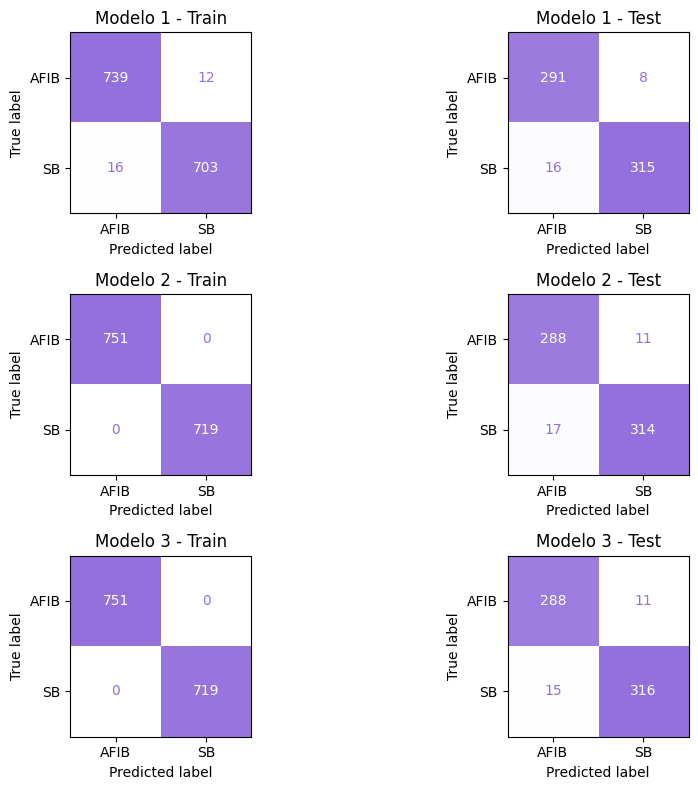

Modelo 1 - Reporte de clasificación (Train):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       751
           1       0.98      0.98      0.98       719

    accuracy                           0.98      1470
   macro avg       0.98      0.98      0.98      1470
weighted avg       0.98      0.98      0.98      1470

Modelo 1 - Reporte de clasificación (Test):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       299
           1       0.98      0.95      0.96       331

    accuracy                           0.96       630
   macro avg       0.96      0.96      0.96       630
weighted avg       0.96      0.96      0.96       630


Modelo 2 - Reporte de clasificación (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       751
           1       1.00      1.00      1.00       719

    accuracy                           1.00    

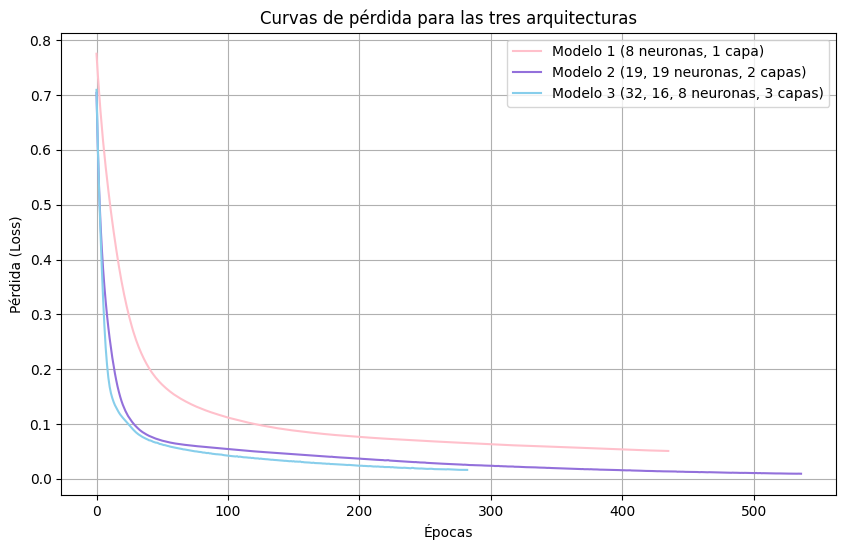

In [ ]:
# Arquitectura 1: Una capa oculta con 8 neuronas
mlp_1 = MLPClassifier(hidden_layer_sizes=(8,), activation='relu', solver='adam', max_iter=1000, random_state=42)
mlp_1.fit(X_train, y_train)

# Arquitectura 2: Dos capas ocultas con 38 neuronas cada una
mlp_2 = MLPClassifier(hidden_layer_sizes=(19, 19), activation='relu', solver='adam', alpha=0.01, max_iter=1000, random_state=42)
mlp_2.fit(X_train, y_train)

# Arquitectura 3: Tres capas ocultas con 16,8,4 neuronas cada una
mlp_3 = MLPClassifier(hidden_layer_sizes=(32, 16, 8), activation='relu', solver='adam', alpha=0.05, learning_rate='adaptive',  max_iter=1000, random_state=42)
mlp_3.fit(X_train, y_train)

# Predicciones para cada modelo
predict_train_1 = mlp_1.predict(X_train)
predict_test_1 = mlp_1.predict(X_test)

predict_train_2 = mlp_2.predict(X_train)
predict_test_2 = mlp_2.predict(X_test)

predict_train_3 = mlp_3.predict(X_train)
predict_test_3 = mlp_3.predict(X_test)

# Matrices de confusión
cm_train_1 = confusion_matrix(y_train, predict_train_1)
cm_test_1 = confusion_matrix(y_test, predict_test_1)

cm_train_2 = confusion_matrix(y_train, predict_train_2)
cm_test_2 = confusion_matrix(y_test, predict_test_2)

cm_train_3 = confusion_matrix(y_train, predict_train_3)
cm_test_3 = confusion_matrix(y_test, predict_test_3)

# Visualizar matrices de confusión
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

from matplotlib.colors import LinearSegmentedColormap
pink_cmap = LinearSegmentedColormap.from_list("custom_pink", ["white", "mediumpurple"])

# Modelo 1
ConfusionMatrixDisplay(cm_train_1, display_labels=["AFIB", "SB"]).plot(ax=axes[0, 0], cmap=pink_cmap, colorbar=False)
axes[0, 0].set_title("Modelo 1 - Train")
ConfusionMatrixDisplay(cm_test_1, display_labels=["AFIB", "SB"]).plot(ax=axes[0, 1], cmap=pink_cmap, colorbar=False)
axes[0, 1].set_title("Modelo 1 - Test")

# Modelo 2
ConfusionMatrixDisplay(cm_train_2, display_labels=["AFIB", "SB"]).plot(ax=axes[1, 0], cmap=pink_cmap, colorbar=False)
axes[1, 0].set_title("Modelo 2 - Train")
ConfusionMatrixDisplay(cm_test_2, display_labels=["AFIB", "SB"]).plot(ax=axes[1, 1], cmap=pink_cmap, colorbar=False)
axes[1, 1].set_title("Modelo 2 - Test")

# Modelo 3
ConfusionMatrixDisplay(cm_train_3, display_labels=["AFIB", "SB"]).plot(ax=axes[2, 0], cmap=pink_cmap, colorbar=False)
axes[2, 0].set_title("Modelo 3 - Train")
ConfusionMatrixDisplay(cm_test_3, display_labels=["AFIB", "SB"]).plot(ax=axes[2, 1], cmap=pink_cmap, colorbar=False)
axes[2, 1].set_title("Modelo 3 - Test")

plt.tight_layout()
plt.show()

# Imprimir reportes de clasificación para cada modelo
print("Modelo 1 - Reporte de clasificación (Train):")
print(classification_report(y_train, predict_train_1))
print("Modelo 1 - Reporte de clasificación (Test):")
print(classification_report(y_test, predict_test_1))

print("\nModelo 2 - Reporte de clasificación (Train):")
print(classification_report(y_train, predict_train_2))
print("\nModelo 2 - Reporte de clasificación (Test):")
print(classification_report(y_test, predict_test_2))

print("\nModelo 3 - Reporte de clasificación (Train):")
print(classification_report(y_train, predict_train_3))
print("\nModelo 3 - Reporte de clasificación (Test):")
print(classification_report(y_test, predict_test_3))

# Gráficas de la función de pérdida (Loss Curve)
plt.figure(figsize=(10, 6))

# Modelo 1
plt.plot(mlp_1.loss_curve_, label="Modelo 1 (8 neuronas, 1 capa)", color='pink')

# Modelo 2
plt.plot(mlp_2.loss_curve_, label="Modelo 2 (19, 19 neuronas, 2 capas)", color='mediumpurple')

# Modelo 3
plt.plot(mlp_3.loss_curve_, label="Modelo 3 (32, 16, 8 neuronas, 3 capas)", color='skyblue')

plt.title("Curvas de pérdida para las tres arquitecturas")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.grid()
plt.show()

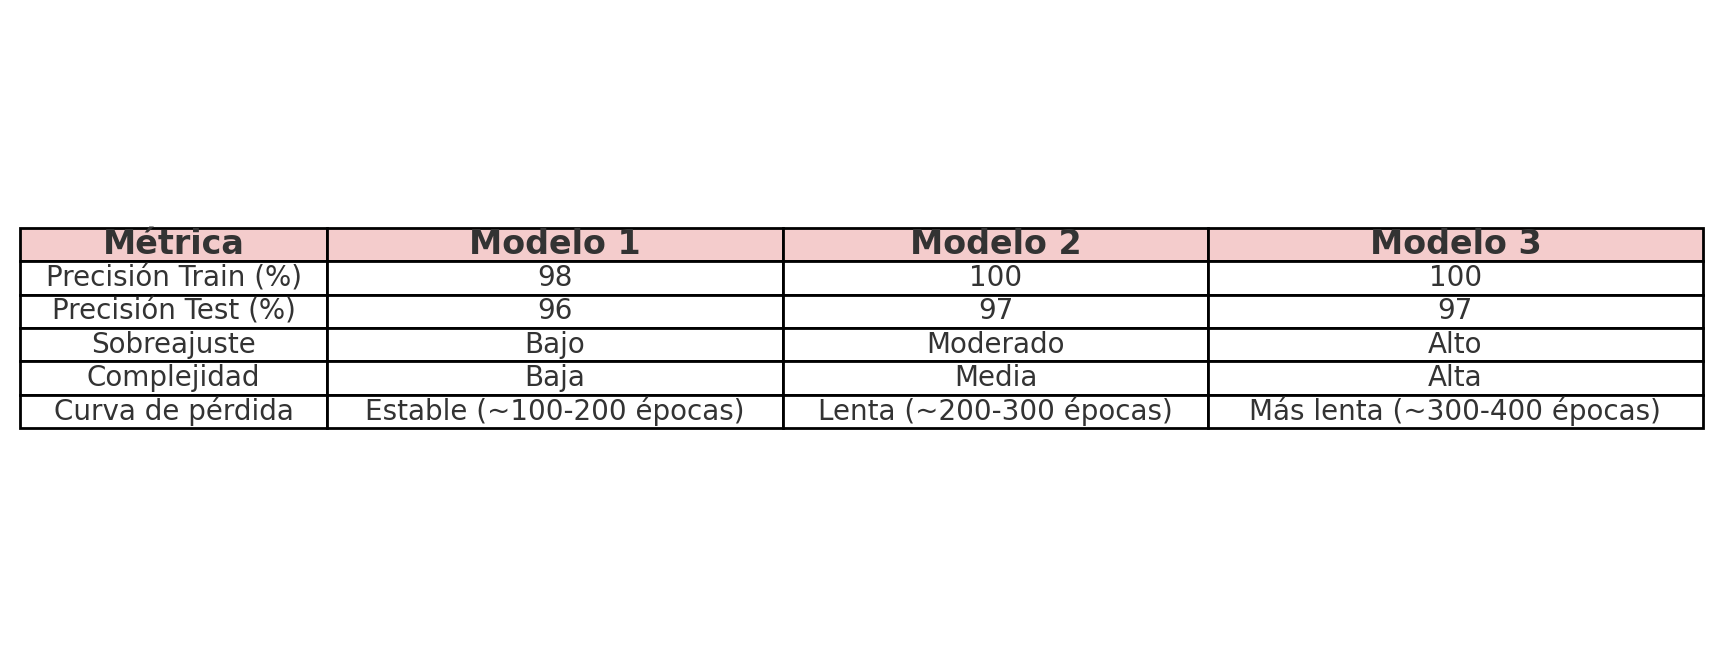

El análisis de los resultados se estructura considerando los aspectos fundamentales del desempeño de los modelos entrenados, las configuraciones de las arquitecturas, las funciones de activación, los solvers, y las técnicas utilizadas para optimizar el rendimiento.

En primer lugar, se implementaron tres arquitecturas de redes neuronales artificiales utilizando el algoritmo Multi-Layer Perceptron (MLP). **El modelo 1**, con una sola capa oculta de 8 neuronas, mostró ser el más simple pero también el más eficiente en términos de generalización, como se observa en los reportes de clasificación y las matrices de confusión. Este modelo logra un equilibrio entre precisión, recall y puntaje F1 tanto en los conjuntos de entrenamiento como de prueba. La simplicidad de este modelo implica que hay menor riesgo de sobreajuste, lo cual se evidencia en que su desempeño en el conjunto de prueba es comparable al del conjunto de entrenamiento.

**El modelo 2** presentó dos capas ocultas de 19 neuronas cada una y un valor de alpha configurado en 0.01. Alpha, en este caso, actúa como un hiperparámetro de regularización L2, cuyo objetivo es penalizar modelos excesivamente complejos y reducir el riesgo de sobreajuste. Sin embargo, los resultados indican que, con esta configuración, el modelo logra una precisión y recall cercanos al modelo 1, pero no se optimizó completamente. Esto sugiere que un ajuste más fino del valor de alpha, junto con una revisión de la tasa de aprendizaje, podría mejorar significativamente el desempeño de este modelo. Es importante resaltar que la tasa de aprendizaje fija puede haber limitado el potencial de este modelo para adaptarse a patrones más complejos en los datos.

**El modelo 3**, con una arquitectura más profunda de tres capas ocultas (32, 16 y 8 neuronas), incluye un valor de alpha más alto (0.05) y utiliza una tasa de aprendizaje adaptativa. Aunque este modelo logró mejores resultados en el conjunto de entrenamiento, con precisión, recall y puntajes F1 perfectos, se observa un leve descenso en el conjunto de prueba, lo cual puede indicar un posible sobreajuste. La tasa de aprendizaje adaptativa permitió ajustar los pesos del modelo de manera más precisa durante el entrenamiento, pero esta mejora no fue suficiente para garantizar una generalización superior.

En términos de las **funciones de activación**, se realizaron pruebas con varias opciones como tanh y sigmoid. Sin embargo, estas resultaron ser más lentas en converger y menos efectivas en comparación con ReLU (Rectified Linear Unit), que se utilizó finalmente en todas las arquitecturas debido a su eficiencia computacional y mejor desempeño al manejar problemas de desaparición del gradiente.

Con respecto al **solver**, inicialmente se evaluaron varias opciones, pero Adam fue el elegido por su capacidad para manejar datos ruidosos y dinámicas no estacionarias en el aprendizaje, mostrando una convergencia más estable en los modelos implementados.

En las **curvas de pérdida** se observa que, si bien todos los modelos convergen hacia valores bajos de pérdida, el modelo 1 lo hace de manera más estable, mientras que los modelos 2 y 3, especialmente este último, presentan una convergencia más rápida pero potencialmente influenciada por el sobreajuste debido a su mayor complejidad.

Considerando los anterior, se puede decir que el modelo 1 resulta ser el más adecuado considerando la simplicidad de su arquitectura y su balance entre entrenamiento y prueba. El modelo 2 tiene el potencial de alcanzar o incluso superar el rendimiento del modelo 1 si se ajustan mejor los hiperparámetros, especialmente alpha y la tasa de aprendizaje. Finalmente, el modelo 3, aunque prometedor, requiere estrategias más avanzadas para controlar el sobreajuste y maximizar su capacidad de generalización. Esto demuestra la importancia de encontrar un equilibrio entre la complejidad del modelo y su capacidad para aprender de los datos sin memorizar.

# 8. Algoritmos Kmeans - SVM

## Algoritmo K-means: Conceptos y Funcionamiento

El algoritmo **K-means** es un método de agrupamiento (*clustering*) ampliamente utilizado en aprendizaje no supervisado, cuyo objetivo principal es dividir un conjunto de datos en **K** grupos o clústeres basados en las similitudes entre ellos. Este algoritmo busca minimizar la dispersión dentro de los grupos y maximizar la separación entre ellos [13].

El algoritmo sigue un enfoque iterativo, compuesto por los siguientes pasos básicos:

1. **Inicialización**: Se seleccionan aleatoriamente \( K \) puntos iniciales llamados **centroides**, que representarán el centro de cada clúster.
2. **Asignación de puntos**: Cada punto del conjunto de datos se asigna al clúster cuyo centroide esté más cerca, calculando distancias mediante una métrica como la euclidiana.
3. **Actualización de centroides**: Se calcula un nuevo centroide para cada clúster como el promedio de los puntos asignados a ese grupo.
4. **Repetición**: Los pasos 2 y 3 se repiten hasta que los centroides ya no cambien significativamente o hasta alcanzar un número máximo de iteraciones.

El objetivo matemático de K-means es minimizar la **inercia intra-clúster**, que se define como la suma de las distancias al cuadrado entre cada punto y el centroide del clúster al que pertenece:

$$
\text{Inercia} = \sum_{i=1}^{K} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

Donde:

$$
\begin{aligned}
&\mathbf{K}: \text{ Número de clústeres.} \\
&\mathbf{C_i}: \text{ El conjunto de puntos pertenecientes al clúster } i. \\
&\boldsymbol{\mu_i}: \text{ El centroide del clúster } i. \\
&\| \mathbf{x} - \boldsymbol{\mu_i} \|^2: \text{ Distancia al cuadrado entre un punto } x \text{ y su centroide.}
\end{aligned}
$$

<br><br>

Este algoritmo se caracteriza por su **simplicidad** y **eficiencia**, pero también presenta algunas limitaciones. Por ejemplo, requiere que el número de clústeres (\( K \)) se defina previamente, lo que puede ser difícil si no se tiene conocimiento previo de los datos. Además, es sensible a la inicialización de los centroides y a la presencia de *outliers*, lo que puede llevar a resultados subóptimos [14].

## Selección del número óptimo de clústeres

Para determinar el valor de \( K \), se utiliza frecuentemente el **método del codo** (*Elbow Method*). Este consiste en calcular la inercia para distintos valores de \( K \) y graficarla. El punto donde la disminución de la inercia se vuelve menos significativa (formando un "codo" en la gráfica) indica un valor razonable para \( K \) [15].

## Ventajas y limitaciones del algoritmo

Entre las ventajas de K-means se encuentran su rápida convergencia y facilidad de implementación. Sin embargo, asume que los clústeres tienen formas esféricas y tamaños similares, lo que puede ser una limitación en datos más complejos [16]. Además, su desempeño se ve afectado por la presencia de ruido o valores atípicos.


## Ejemplo K-means

In [ ]:
print(df_total_zscore.groupby('Rhythm').size())

Rhythm
0    1050
1    1050
dtype: int64


### Relación catergorías

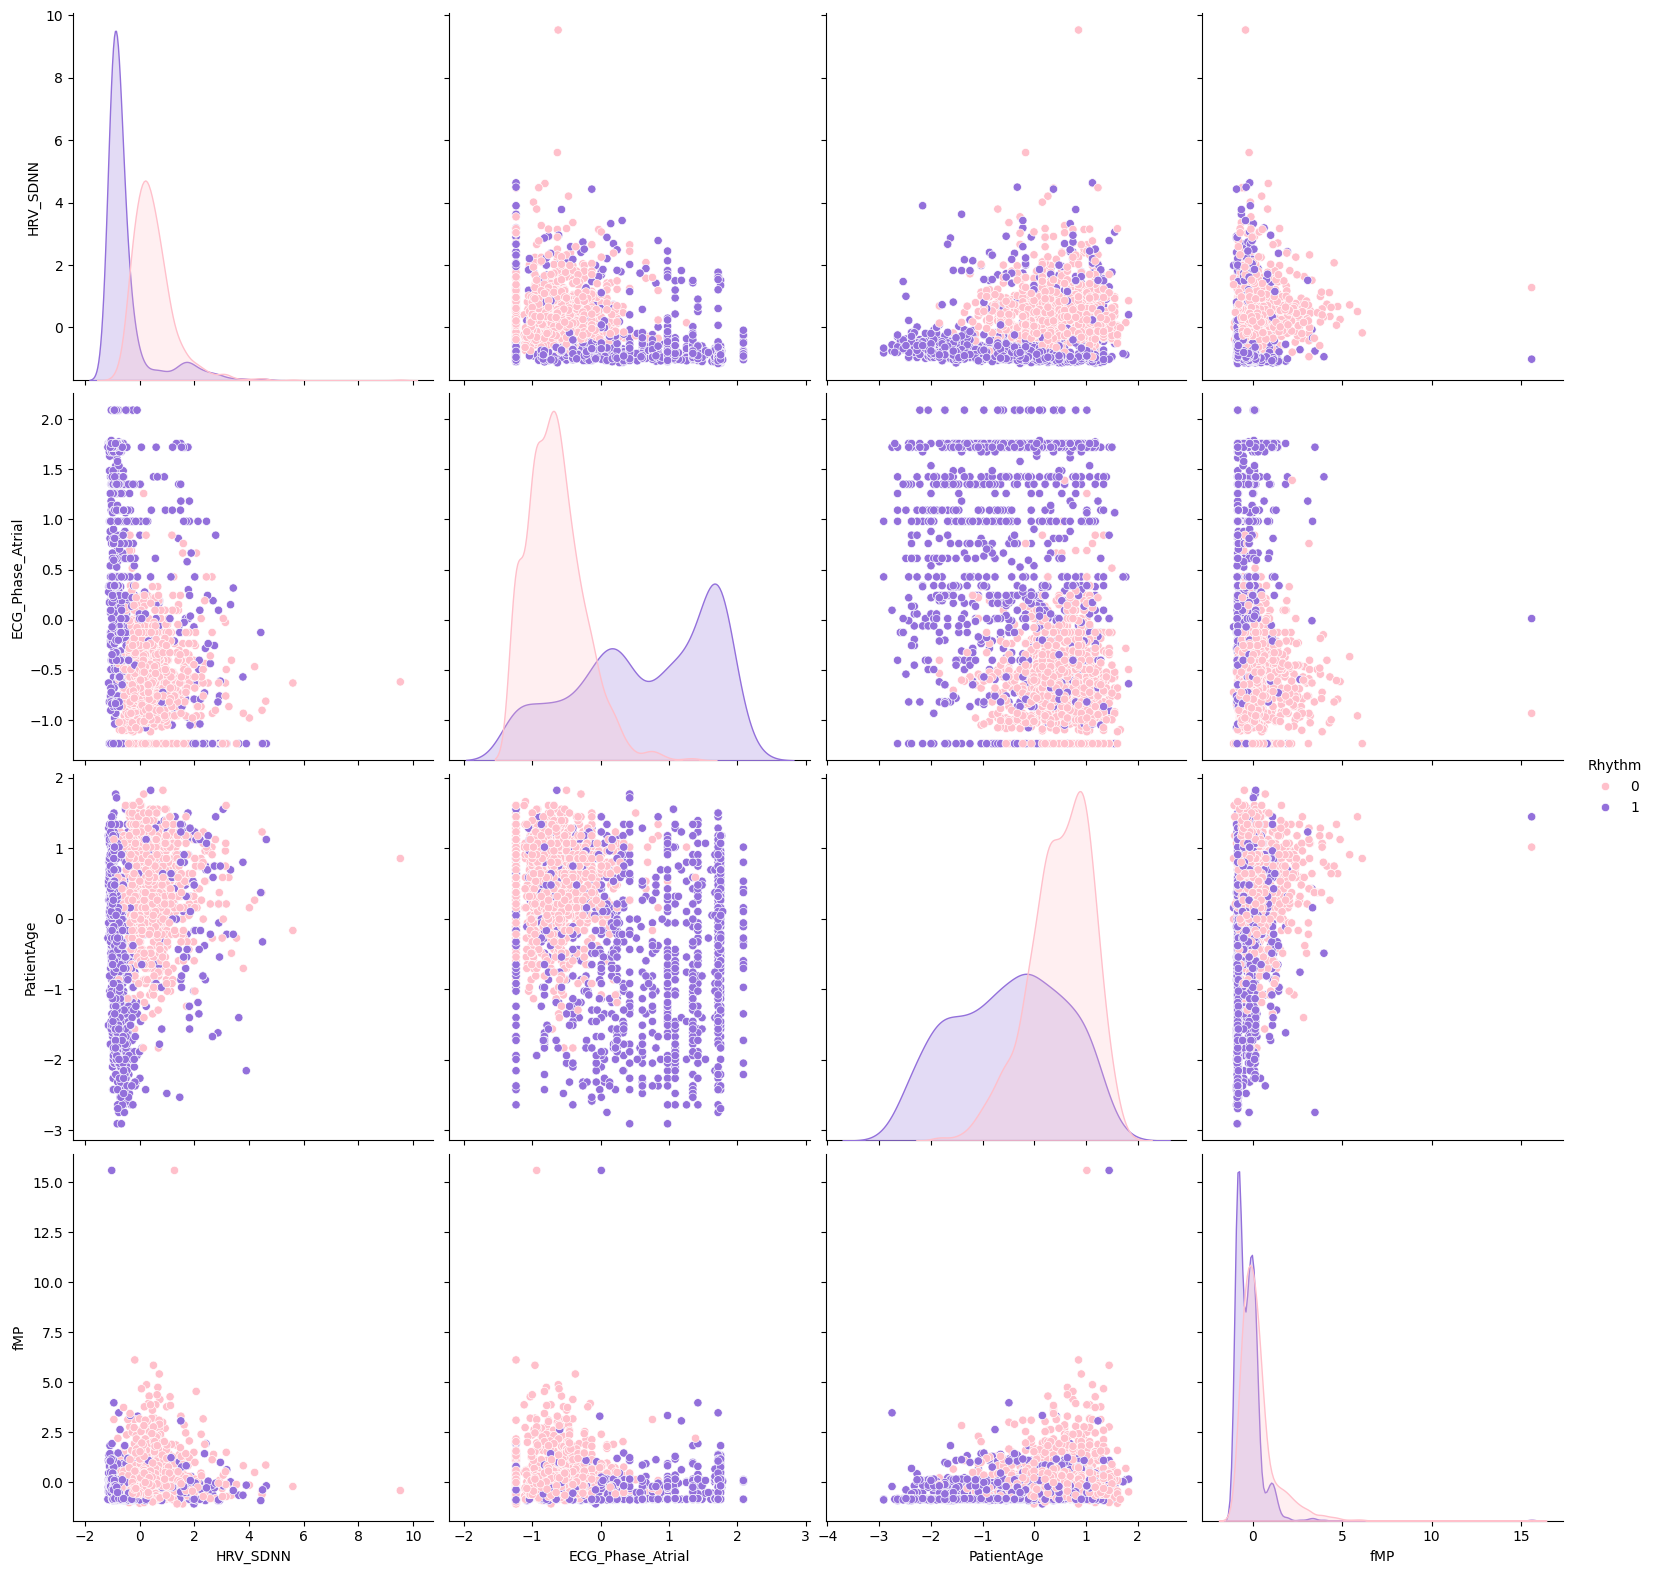

In [ ]:
import seaborn as sns
custom_palette = ["pink", "mediumpurple"]

# Crear el gráfico pairplot con los colores personalizados
sns.pairplot(
    df_total_zscore.dropna(),
    hue="Rhythm",
    height=4,  # Cambié de size a height según la versión de Seaborn
    vars=["HRV_SDNN", "ECG_Phase_Atrial", "PatientAge", "fMP"],
    kind="scatter",
    palette=custom_palette  # Usar la paleta personalizada
)

### Kmeans clustering

Centroides de los clusters:
[[-0.54928876  0.08343937 -0.29849479  0.70712148 -0.80064664  0.7377309
  -0.63562225  0.85316151 -0.59323304  0.05051782 -1.0528218 ]
 [ 0.49555399 -0.07527682  0.26929421 -0.63794655  0.72232252 -0.66556158
   0.57344181 -0.76970005  0.53519937 -0.04557586  0.94982836]]


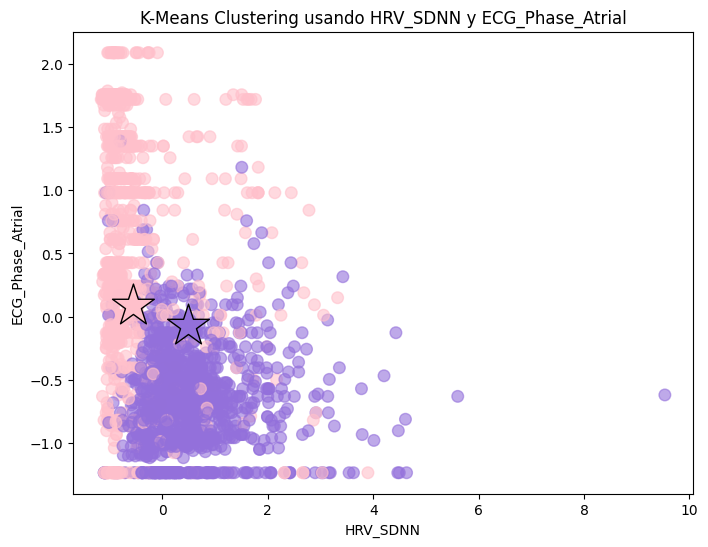

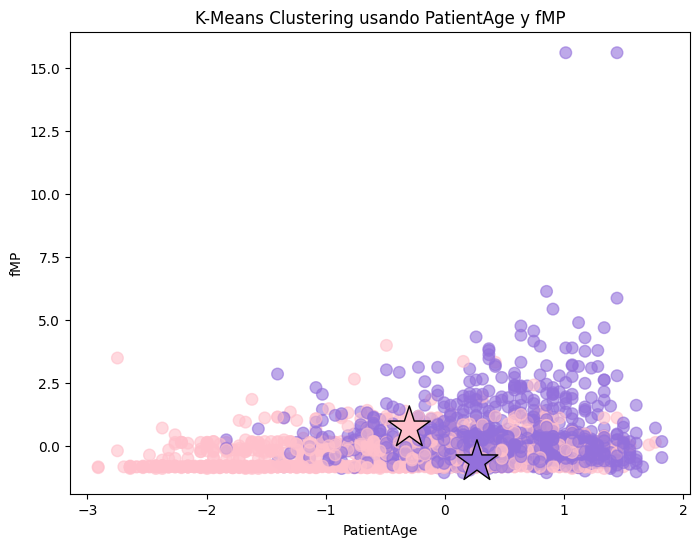

In [ ]:
# Definimos las características de entrada
X = np.array(df_total_zscore.drop(columns=['Rhythm']))
y = np.array(df_total_zscore['Rhythm'])  # Aunque 'Rhythm' no se utiliza para entrenar K-Means

# Estandarización (ya parece estar hecho, pero se incluye como referencia)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicamos el algoritmo K-Means con todas las características
kmeans = KMeans(n_clusters=2, random_state=123).fit(X_scaled)
centroids = kmeans.cluster_centers_

# Mostramos los centroides
print("Centroides de los clusters:")
print(centroids)

# Predicción de los clusters
labels = kmeans.predict(X_scaled)

# Colores personalizados para los clusters
colores = ['pink', 'mediumpurple']
asignar = [colores[label] for label in labels]

# Visualización en función de dos características
# Aquí elegimos 'HRV_SDNN' y 'ECG_Phase_Atrial', pero puedes cambiarlo
f1 = df_total_zscore['HRV_SDNN'].values
f2 = df_total_zscore['ECG_Phase_Atrial'].values

plt.figure(figsize=(8, 6))
plt.scatter(f1, f2, c=asignar, s=70, alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c=colores, s=1000, edgecolor='black')
plt.title('K-Means Clustering usando HRV_SDNN y ECG_Phase_Atrial')
plt.xlabel('HRV_SDNN')
plt.ylabel('ECG_Phase_Atrial')
plt.show()

# Visualización con otras características
f1 = df_total_zscore['PatientAge'].values
f2 = df_total_zscore['fMP'].values

plt.figure(figsize=(8, 6))
plt.scatter(f1, f2, c=asignar, s=70, alpha=0.6)
plt.scatter(centroids[:, 2], centroids[:, 3], marker='*', c=colores, s=1000, edgecolor='black')
plt.title('K-Means Clustering usando PatientAge y fMP')
plt.xlabel('PatientAge')
plt.ylabel('fMP')
plt.show()


## Algoritmo SVM (Máquinas de Soporte Vectorial): Conceptos y Funcionamiento

El algoritmo de **Máquinas de Soporte Vectorial (Support Vector Machines, SVM)** es un modelo supervisado ampliamente utilizado para problemas de clasificación y regresión. Su objetivo es encontrar el **hiperplano óptimo** que separa las clases, maximizando el margen, es decir, la distancia entre el hiperplano y las observaciones más cercanas de cada clase, llamadas **vectores soporte** [17].

El hiperplano que separa las clases se define como:

$$
\mathbf{w} \cdot \mathbf{x} + b = 0
$$

Donde:

$$
\begin{aligned}
&\mathbf{w}: &\text{El vector de pesos.} \\
&\mathbf{x}: &\text{El vector de características.} \\
&b: &\text{El sesgo.}
\end{aligned}
$$

<br><br>

El modelo optimiza w y b para maximizar el margen y lograr una separación robusta entre las clases.

Cuando los datos no son linealmente separables, SVM utiliza **funciones kernel** para transformar los datos a un espacio de mayor dimensión donde las clases puedan ser separadas linealmente. Algunos de los kernels más comunes incluyen:
- **Kernel lineal**: adecuado para datos que ya son aproximadamente linealmente separables.
- **Kernel polinómico**: permite capturar relaciones no lineales entre las características.
- **Kernel de base radial (RBF)**: genera fronteras de decisión curvas que se adaptan mejor a datos complejos [18].

### Parámetros clave

El comportamiento de SVM puede ajustarse mediante los parámetros (C) y (gamma):

- **C**: controla el equilibrio entre margen amplio y errores de clasificación. Valores altos de \( C \) intentan minimizar los errores del modelo pero pueden sobreajustar, mientras que valores bajos favorecen márgenes más amplios.

- **gamma**: en kernels como RBF, determina la influencia de cada punto de datos. Valores altos producen fronteras de decisión más ajustadas y sensibles a puntos individuales, mientras que valores bajos generan fronteras más suaves [19].

### Ventajas y Limitaciones

SVM es ideal para problemas con muchas características en comparación con el número de observaciones, ofreciendo robustez frente al sobreajuste si los parámetros son seleccionados correctamente. Sin embargo, para conjuntos de datos muy grandes, el entrenamiento puede ser computacionalmente costoso, lo que limita su aplicabilidad [20].



## Ejemplo - SVM

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


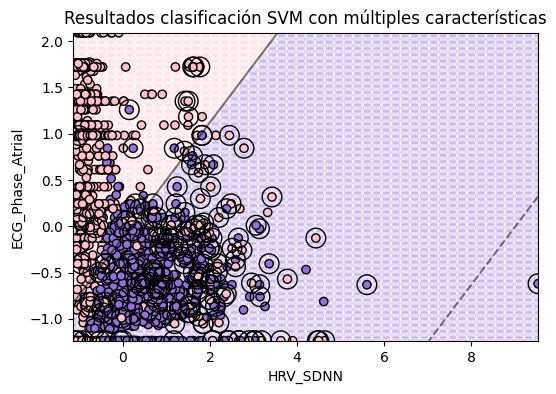

In [ ]:
# Seleccionar todas las características excepto la etiqueta
X = df_total_zscore.drop(columns='Rhythm')
y = df_total_zscore['Rhythm']

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1234, shuffle=True
)

# Crear el modelo SVM lineal con todas las características
modelo = SVC(C=100, kernel='linear', random_state=123)
modelo.fit(X_train, y_train)

# Seleccionar dos características para la representación gráfica
feature_x = 'HRV_SDNN'
feature_y = 'ECG_Phase_Atrial'

# Crear el grid de valores
x = np.linspace(X_train[feature_x].min(), X_train[feature_x].max(), 50)
y = np.linspace(X_train[feature_y].min(), X_train[feature_y].max(), 50)
Y, X = np.meshgrid(y, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

# Crear un DataFrame para predecir con las demás características fijas
grid_full = np.zeros((grid.shape[0], X_train.shape[1]))
for i, col in enumerate(X_train.columns):
    if col == feature_x:
        grid_full[:, i] = grid[:, 0]
    elif col == feature_y:
        grid_full[:, i] = grid[:, 1]
    else:
        grid_full[:, i] = X_train[col].mean()  # Usar la media para las otras características

# Predicción en el grid
pred_grid = modelo.predict(grid_full)

# Representar el resultado
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(grid[:, 0], grid[:, 1], c=pred_grid, alpha=0.2, cmap=ListedColormap(['mediumpurple', 'pink']))
ax.scatter(X_train[feature_x], X_train[feature_y], c=y_train, cmap=ListedColormap(['mediumpurple', 'pink']), edgecolor='k')
ax.scatter(
    modelo.support_vectors_[:, X_train.columns.get_loc(feature_x)],
    modelo.support_vectors_[:, X_train.columns.get_loc(feature_y)],
    s=200, facecolors='none', edgecolors='black'
)
ax.contour(
    X,
    Y,
    modelo.decision_function(grid_full).reshape(X.shape),
    colors='k',
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=['--', '-', '--']
)

ax.set_title("Resultados clasificación SVM con múltiples características")
ax.set_xlabel(feature_x)
ax.set_ylabel(feature_y)
plt.show()


# 9. Equipos comerciales con algoritmos incorporados

**Cardiógrafos PageWriter TC70 - Phillips**

El equipo PageWriter TC70 es un cardiógrafo avanzado que incorpora el algoritmo DXL, una herramienta diseñada para ofrecer un análisis detallado y diagnóstico basado en señales electrocardiográficas. Este algoritmo, integrado en el sistema, permite interpretar señales de hasta 16 derivaciones, ampliando las capacidades tradicionales de los equipos estándar de 12 derivaciones. Esto resulta especialmente útil para evaluar condiciones cardíacas complejas, como isquemias o infartos, al incluir derivaciones adicionales que proporcionan una visión más completa del funcionamiento eléctrico del corazón.

El algoritmo DXL realiza un análisis automatizado de las señales ECG, comenzando por verificar la calidad de la señal capturada para garantizar que los datos sean precisos y confiables. Utiliza técnicas avanzadas para identificar y medir las ondas del complejo P-QRS-T en cada derivación, analizando tanto la morfología como el ritmo cardíaco. Además, es capaz de detectar latidos dominantes y la presencia de marcapasos, asegurando un diagnóstico más preciso en una amplia gama de escenarios clínicos.

Una de las características destacadas del algoritmo es su capacidad para generar mapas de desviaciones del segmento ST, conocidos como mapas ST, que representan visualmente las posibles áreas afectadas por isquemia o infarto. Además, incorpora criterios específicos para identificar la arteria culpable en casos de infarto de miocardio con elevación del segmento ST (STEMI). Estas funcionalidades permiten al personal médico identificar rápidamente condiciones críticas y priorizar la atención del paciente.

El sistema también incluye herramientas inteligentes, como el programa LeadCheck, que ayuda a identificar errores en la colocación de los electrodos durante la adquisición de los datos, mejorando la precisión del análisis. Asimismo, el algoritmo está diseñado para proporcionar advertencias automáticas sobre condiciones que requieren intervención médica urgente, como infartos agudos o ciertas arritmias graves [7-8].

**MARS Ambulatory ECG System - GE HealthCare**

El Sistema de ECG Ambulatorio MARS de GE Healthcare incorpora una serie de algoritmos avanzados conocidos como Marquette, diseñados específicamente para ofrecer análisis detallados de señales cardíacas en pacientes ambulatorios. Estos algoritmos permiten la evaluación de diferentes parámetros cardíacos y apoyan el diagnóstico clínico a través de herramientas automatizadas que han sido validadas en estudios clínicos y se han establecido como un estándar en el análisis de ECG.

Uno de los elementos clave del sistema es el análisis de 12 derivaciones a través del programa Marquette 12SL. Este algoritmo es capaz de proporcionar mediciones exactas de frecuencia cardíaca, intervalos, ejes eléctricos y duraciones, lo que garantiza un análisis completo de las señales electrocardiográficas. Además, el algoritmo incorpora criterios específicos basados en la edad y el género del paciente, lo que mejora su capacidad para identificar condiciones como infartos agudos de miocardio o alteraciones en la conducción eléctrica, adaptándose a las características individuales de cada paciente. Esto lo convierte en una herramienta útil tanto para el diagnóstico inicial como para el seguimiento a largo plazo.

Otra funcionalidad destacada es la capacidad de los algoritmos de Marquette para detectar arritmias cardíacas, incluyendo fibrilación auricular, mediante el análisis simultáneo de múltiples derivaciones. Esta capacidad es crucial para identificar patrones anormales de ritmo que podrían pasar desapercibidos en una revisión manual. Además, el sistema también realiza un análisis detallado del intervalo QT, proporcionando información en tiempo real sobre la posible prolongación de este intervalo, un indicador importante de riesgo de arritmias graves como torsades de pointes.

El Sistema MARS también integra el análisis de la alternancia de la onda T (T-wave Alternans o TWA), una característica que detecta pequeñas variaciones en la morfología de la onda T a lo largo del tiempo. Este análisis es particularmente útil para identificar a pacientes con un alto riesgo de muerte súbita cardíaca. Junto con esta funcionalidad, los algoritmos evalúan la turbulencia de la frecuencia cardíaca (Heart Rate Turbulence o HRT), que analiza cómo responde la frecuencia cardíaca después de contracciones ventriculares prematuras, y la variabilidad de la frecuencia cardíaca (Heart Rate Variability o HRV), que mide cambios sutiles en los intervalos entre latidos para evaluar el estado del sistema nervioso autónomo del paciente.

Además, el sistema está equipado con herramientas para la detección de actividad de marcapasos, proporcionando un análisis detallado de la función de estos dispositivos, lo que facilita la detección temprana de posibles problemas y permite ajustes oportunos en la programación del dispositivo [9-10].

**CardioCare 2000 - Bionet**

El CardioCare 200 de Bionet es un electrocardiógrafo digital interpretativo de 12 canales diseñado para capturar y analizar señales electrocardiográficas (ECG) de manera precisa y eficiente. Este dispositivo permite la adquisición simultánea de datos de 12 derivaciones, proporcionando una visión integral de la actividad eléctrica del corazón. Su algoritmo de interpretación avanzado ofrece más de 130 tipos de resultados basados en el código de Minnesota, facilitando la identificación de diversas anomalías cardíacas. Además, el CardioCare 2000 es compatible con el software BMS-Plus, que permite la gestión de datos desde un PC a través de LAN y la transferencia de información a sistemas HIS (PACS/EMR) en múltiples formatos de archivo, como JPEG, BMP, XML, PDF y MFER.

Por otro lado, el **KardiaMobile 6L** de AliveCor es un dispositivo portátil que permite a los usuarios registrar electrocardiogramas de grado médico directamente en su smartphone o tablet. Equipado con tres electrodos, el KardiaMobile 6L puede capturar ECG de una derivación y de seis derivaciones, proporcionando una visión detallada de la actividad cardíaca. Este dispositivo es capaz de detectar arritmias comunes, incluyendo fibrilación auricular, bradicardia y taquicardia. La información recopilada se transmite de forma inalámbrica a la aplicación móvil, donde los usuarios pueden revisar y compartir los resultados con sus médicos. El KardiaMobile 6L ha sido aprobado por la FDA y cuenta con la marca CE, lo que respalda su eficacia y seguridad en el monitoreo cardíaco personal.

Ambos dispositivos representan avances significativos en el monitoreo y análisis de la salud cardíaca, ofreciendo herramientas que combinan precisión clínica con facilidad de uso, adaptándose a las necesidades tanto de profesionales de la salud como de pacientes.

**Plataforma Willen - Idoven**

La Plataforma Willem de Idoven es una herramienta avanzada basada en la nube, diseñada para analizar señales de electrocardiogramas (ECG) utilizando inteligencia artificial. Esta plataforma permite a los profesionales de la salud identificar con precisión múltiples patrones cardíacos y evaluar parámetros clave como los intervalos P, PR, QT y la duración del complejo QRS. Gracias a su diseño, es compatible con diversos dispositivos de registro de ECG, desde los estándar de 12 derivaciones hasta monitores Holter, parches de una o dos derivaciones y monitores cardíacos insertables (MCI).

Impulsada por algoritmos de inteligencia artificial entrenados con millones de registros de ECG, Willem es capaz de reconocer patrones complejos en las señales cardíacas, lo que permite detectar anomalías como arritmias, isquemias y otros trastornos cardiovasculares con una precisión significativa. Este sistema se ha diseñado para procesar grandes volúmenes de datos en tiempo real, ofreciendo resultados en cuestión de minutos, lo que facilita la toma de decisiones clínicas rápidas y bien informadas.

El algoritmo de Willem ha sido desarrollado mediante técnicas de aprendizaje supervisado, utilizando datos etiquetados por expertos en cardiología, lo que garantiza su capacidad para analizar con precisión cada latido cardíaco. Este enfoque le permite identificar hasta 22 patrones cardíacos distintos, ampliando significativamente la capacidad de detección en comparación con métodos tradicionales. Además, estudios clínicos han validado la eficacia de esta tecnología, demostrando que mejora la detección de patrones cardíacos en dispositivos como los monitores cardíacos insertables, pasando de 4 a 25 patrones detectables, con una precisión promedio del 88%. También ha reducido el tiempo de interpretación de señales de 11 minutos a solo 6 segundos.

La plataforma está diseñada para integrarse sin problemas con sistemas clínicos existentes, como herramientas de monitorización cardíaca y sistemas de gestión de información médica. Ofrece informes electrónicos que pueden compartirse fácilmente a través de correo electrónico, sistemas EMR o el portal de resultados de Idoven, lo que la convierte en una solución práctica y adaptable para diversos entornos médicos [11-12].


#Conclusión

Este trabajo permitió analizar y clasificar señales electrocardiográficas (ECG) combinando técnicas avanzadas de procesamiento de señales, extracción de características y aprendizaje automático. El uso de herramientas como NeuroKit y métodos para equilibrar y estandarizar datos fue importante para mejorar la calidad de la información, reduciendo el ruido y posibles errores. La elección de modelos neuronales con funciones como ReLU y el solver Adam destacó la importancia de seleccionar configuraciones simples y efectivas que permitan un buen desempeño y eviten problemas de sobreajuste. También se identificó que parámetros como alpha (usado para controlar la regularización) y la tasa de aprendizaje son claves para ajustar y mejorar los resultados de los modelos, dependiendo de los datos específicos. Además, la comparación con métodos más clásicos como K-means y SVM mostró que las redes neuronales tienen ventajas significativas al trabajar con datos más complejos, aunque cada enfoque tiene sus propias limitaciones. Puede decirse que, este proyecto, ayudó a comprender bases importantes para crear herramientas diagnósticas que puedan usarse en dispositivos médicos modernos y prácticos en el entorno clínico.

# Referencias

[1] J. Zheng et al., "Optimal Multi-Stage Arrhythmia Classification Approach," Scientific Reports, vol. 10, no. 2898, pp. 1-12, Feb. 2020, doi: 10.1038/s41598-020-59821-7.

[2] J. Xie, S. Stavrakis y B. Yao, "Automated Identification of Atrial Fibrillation from Single-Lead ECGs Using Multi-Branching ResNet," Frontiers in Physiology, vol. 15, art. 1362185, pp. 1-14, Apr. 2024, doi: 10.3389/fphys.2024.1362185.

[3] R. Z. Rashid, M. Al-Ani, and S. S. Nair, “A Deep Learning Method for Beat-Level Risk Analysis and Interpretation of Atrial Fibrillation Patients during Sinus Rhythm,” *Frontiers in Cardiovascular Medicine*, vol. 9, 2022. [Online]. Available: https://www.frontiersin.org/articles/10.3389/fcvm.2022.784605/full. [Accessed: Nov. 29, 2024].

[4] M. Xu, Z. Dong, and Q. Wang, “Deciphering Heartbeat Signatures: A Vision Transformer Approach to Explainable Atrial Fibrillation Detection from ECG Signals,” *IEEE Journal of Biomedical and Health Informatics*, vol. 26, no. 5, pp. 1783-1793, May 2022. [Online]. Available: https://doi.org/10.1109/JBHI.2022.3164219. [Accessed: Nov. 29, 2024].

[5] S. Agarwal, K. Sankar, and R. Mehra, “Arrhythmia Classification from the Abductive Interpretation of Short Single-Lead ECG Records,” *Biomedical Signal Processing and Control*, vol. 74, pp. 1-8, 2022. [Online]. Available: https://doi.org/10.1016/j.bspc.2021.103541. [Accessed: Nov. 29, 2024].

[6] T. Berger, H. Schramm, and U. Schweikert, “A Singular-value-based Marker for the Detection of Atrial Fibrillation Using High-resolution Electrograms and Multi-lead ECG,” *Computers in Biology and Medicine*, vol. 134, 2021. [Online]. Available: https://doi.org/10.1016/j.compbiomed.2021.104551. [Accessed: Nov. 29, 2024].

[7] Philips - Cardiógrafos PageWriter TC70 Cardiógrafo. (s.f.). Philips. https://www.philips.es/healthcare/product/HC860315/cardigrafos-pagewriter-tc70-cardigrafo#documents

[8] Philips Medical Systems, Philips DXL ECG Algorithm Physician’s Guide for PH100B, Edition 2, Koninklijke Philips Electronics N.V., Apr. 2009. [Online]. Available: Philips DXL ECG Guide.

[9] Gatekeeper. (s.f.). GE Healthcare | Volver a | GE HealthCare (Spain). https://www.gehealthcare.es/products/diagnostic-cardiology/analysis-programs/marquette-12sl

[10] GE Healthcare, MARS® Ambulatory ECG Analysis: The Power to Assess and Predict, GE Healthcare, 2023. [Online]. Available: https://www.physiciansresource.net.

[11] Idoven utiliza IA para analizar latidos del corazón como ningún doctor puede hacerlo," Big Data Magazine, [Online]. Available: https://bigdatamagazine.es/la-ia-permite-analizar-los-latidos-del-corazon-como-ningun-doctor-puede-hacerlo. [Accessed: 29-Nov-2024].

[12] Plataforma Willem para el análisis avanzado de ECG," Idoven AI Platform, [Online]. Available: https://es.idoven.ai. [Accessed: 29-Nov-2024].

[13] J. MacQueen, "Some methods for classification and analysis of multivariate observations," in *Proceedings of the Fifth Berkeley Symposium on Mathematical Statistics and Probability*, Berkeley, CA, USA, 1967, pp. 281-297.

[14] S. Lloyd, "Least squares quantization in PCM," *IEEE Transactions on Information Theory*, vol. 28, no. 2, pp. 129-137, Mar. 1982.

[15] R. L. Thorndike, "Who belongs in the family?," *Psychometrika*, vol. 18, pp. 267-276, Dec. 1953.

[16] A. K. Jain, "Data clustering: 50 years beyond K-means," *Pattern Recognition Letters*, vol. 31, no. 8, pp. 651-666, Jun. 2010.

[17] V. Vapnik, *The Nature of Statistical Learning Theory*, 2nd ed., New York, NY, USA: Springer, 1995.

[18] C. Cortes and V. Vapnik, "Support-vector networks," *Machine Learning*, vol. 20, no. 3, pp. 273-297, 1995.

[19] B. Scholkopf and A. J. Smola, *Learning with Kernels: Support Vector Machines, Regularization, Optimization, and Beyond*, Cambridge, MA, USA: MIT Press, 2001.

[20] J. Platt, "Sequential minimal optimization: A fast algorithm for training support vector machines," in *Advances in Kernel Methods: Support Vector Learning*, Cambridge, MA, USA: MIT Press, pp. 185-208, 1998.

